In [1]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

from multiprocessing import Pool
from functools import partial

In [2]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Complete"
directory = DATADIR+"/detect_testSN_07/"
butler = dafPersist.Butler(directory) 
filter = 'r'


In [3]:
stack_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}
snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

In [4]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

dates = []
days_file=open(DATADIR+"/days_07.txt", "rb")

for day in days_file:
    day = day.replace('\n','')
    dates.append(day)

days_file.close()

In [6]:

def get_light_curves_per_patch(butler, filter, dates, patch):

    multi_matches = None
    results = []
    stack_lcs = []
    for date in dates:
        t = Time(date)
        date_catalog = None
        #print date
        if butler.datasetExists("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date}):
            date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date})
            if multi_matches is None:
                multi_matches= afwTable.MultiMatch(date_catalog.schema, {'mjd':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
            multi_matches.add(date_catalog, {'mjd':int(t.mjd)})


    if multi_matches is not None:
        results = multi_matches.finish(removeAmbiguous=False)
        lcs = DSTools.get_light_curves_from_multimatch_results2(results)
        t_lcs = DSTools.threshold_light_curves(lcs, 3)
        for t_lc in t_lcs:
            stack_lcs.append(DSTools.build_lightcurve4(t_lc, "base_CircularApertureFlux_4_5_flux", filter))
            
    return patch, stack_lcs

def function(args):
    return get_light_curves_per_patch(*args)

In [7]:
p = Pool(200)



params = [(butler, filter, dates, patch) for patch in patches]
params2 = [(butler, 'g', dates, patch) for patch in patches]
params3 = [(butler, 'i', dates, patch) for patch in patches]


params.extend(params2)
params.extend(params3)


#butler_z = dafPersist.Butler("/datadec/cppm/jpreyes/CFHT_filter_z/detect_testSN_6") 
params4 = [(butler, 'z', dates, patch) for patch in patches]

params.extend(params4)
#print params
res = p.map(function, params)
#f = Pool(25).map(get_light_curves_per_patch, ([butler], ['g'], ['0,20'], [dates]))

In [8]:
from astropy.table import Table, vstack
lcs = {}
for r in res:
    if len(r[1])>0:
        if lcs.has_key(r[0]):
            lcs[r[0]].extend(r[1])
        else:
            lcs[r[0]] = r[1]

lcs2 = lcs
lcs = lcs.values()
print len(lcs)

420


In [9]:
lcs2.keys()

['22,16',
 '22,17',
 '22,14',
 '22,15',
 '22,12',
 '22,13',
 '22,10',
 '22,11',
 '22,18',
 '22,19',
 '15,14',
 '15,15',
 '15,16',
 '15,17',
 '15,10',
 '15,11',
 '15,12',
 '15,13',
 '15,18',
 '15,19',
 '24,10',
 '23,19',
 '23,18',
 '24,11',
 '23,15',
 '23,14',
 '21,24',
 '23,16',
 '21,22',
 '21,23',
 '21,20',
 '21,21',
 '24,13',
 '11,18',
 '11,19',
 '11,10',
 '11,11',
 '11,12',
 '11,13',
 '11,14',
 '11,15',
 '11,16',
 '11,17',
 '6,15',
 '6,14',
 '6,17',
 '6,16',
 '6,11',
 '6,10',
 '6,13',
 '6,12',
 '6,19',
 '6,18',
 '8,9',
 '8,8',
 '8,7',
 '8,6',
 '8,5',
 '8,4',
 '16,24',
 '16,20',
 '16,21',
 '16,22',
 '16,23',
 '15,24',
 '15,21',
 '15,20',
 '15,23',
 '15,22',
 '13,4',
 '13,5',
 '13,6',
 '13,7',
 '13,8',
 '13,9',
 '17,4',
 '17,5',
 '17,6',
 '17,7',
 '17,8',
 '17,9',
 '8,23',
 '12,20',
 '12,21',
 '12,22',
 '12,23',
 '12,24',
 '11,21',
 '11,20',
 '11,23',
 '11,22',
 '11,24',
 '17,16',
 '17,17',
 '17,14',
 '17,15',
 '17,12',
 '17,13',
 '17,10',
 '17,11',
 '17,18',
 '17,19',
 '6,24',
 '6,20

In [ ]:
test = lcs[0]
import astropy.coordinates as coord
import astropy.units as u
for ls in test:
    c = coord.SkyCoord(ra=float(np.mean(ls['ra'])), dec=float(np.mean(ls['dec'])), unit=(u.rad))
    #print c.ra.deg, c.dec.deg
    wcs = diffexp.getWcs()
    pix = wcs.skyToPixel(afwGeom.Angle(c.ra.rad), afwGeom.Angle(c.dec.rad))
    #print pix
    if ls[0]["bandpass"]=="sdssz":
        ds9.dot('x',pix[0], pix[1], frame=1, size=10, ctype=ds9.RED)
    else:
        ds9.dot('x',pix[0], pix[1], frame=1)

In [10]:


def build_multi_filter_lc(lcs):
    final_lc = []
 
    for lc in lcs:
        added = False
        
        for i, f_lc in enumerate(final_lc):
            s1 = {'ra':np.mean(lc["ra"]), 'dec':np.mean(lc["dec"])}
            s2 = {'ra':np.mean(f_lc["ra"]), 'dec':np.mean(f_lc["dec"])}
      
            if DSTools.source_distance(s1,s2)<1:             
                added = True
                final_lc[i] = vstack([lc, f_lc])
                  #print final_lc[i]
        if added == False:
                  final_lc.append(lc)
                  
    return final_lc
        

In [11]:
p = Pool(100)
mf_lcs = p.map(build_multi_filter_lc, lcs)

In [12]:
tot_lcs = []
for p_lc in mf_lcs:
    tot_lcs.extend(p_lc)

In [18]:
len(tot_lcs)

93521

In [33]:
def match_with_lc_07(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc["ra"], "dec":lc["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):
            #print i
            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

In [19]:
stats = []
for lc in tot_lcs:
    t_by_filter = lc.group_by("bandpass")
    indices = t_by_filter.groups.indices
    stats.append(len(indices)-1)
    

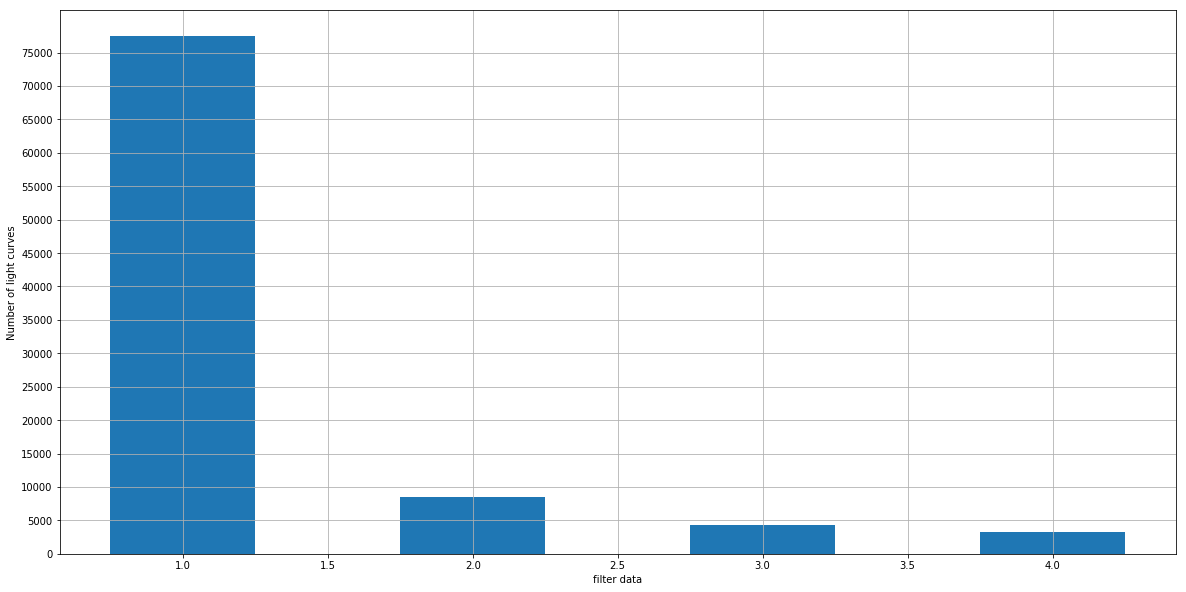

In [21]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.hist(stats, bins=range(1,6,1), align='left', rwidth=0.5)
plt.ylabel("Number of light curves")
plt.xlabel("filter data")
plt.yticks(np.arange(0,80000,5000))
plt.grid(True)
plt.show()

In [ ]:
writable_lcs = []
for lc in tot_lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    if len(indices) > 2:
        writable_lcs.append(lc)

In [46]:
s07_file = open('07D3Season.dat')
lst = []
for line in s07_file:
    lst += [line.split()]
    
coordinates = [x[1]+" "+x[2] for x in lst]

import astropy.coordinates as coord
import astropy.units as u
snls_data = []
for data in coordinates:
    c = coord.SkyCoord(data, unit=(u.hourangle, u.deg))
    snls_data.append({"ra":c.ra.rad,"dec":c.dec.rad})

In [47]:
len(snls_data)

30

In [53]:
for data in coordinates:
    c = coord.SkyCoord(data, unit=(u.hourangle, u.deg))
    print c.ra.deg, c.dec.deg

214.390425 52.5242138889
214.770875 53.1024944444
214.542779167 52.3853833333
215.243366667 52.3436722222
215.3571625 52.9704638889
215.225433333 52.4803416667
214.071895833 52.5396111111
214.1495875 53.0839638889
214.553420833 52.3179361111
215.3259375 52.6751444444
215.235545833 52.2537111111
215.025983333 52.2712888889
215.669979167 53.0374138889
215.148679167 52.7468277778
215.275483333 52.6688555556
215.275483333 52.6688555556
214.892120833 52.4661
214.828933333 53.0766444444
215.353333333 53.1778055556
215.353333333 53.1778055556
214.634670833 52.7248944444
214.758658333 52.6633055556
215.462091667 53.0996277778
214.104779167 53.1426833333
215.310666667 52.7981694444
215.274758333 52.8935055556
215.451708333 52.5093444444
215.123204167 52.3991083333
214.2949625 53.0796972222
214.536375 52.4177944444


In [44]:
matches_45= match_with_lc_07(snls_data, tot_lcs)

76956
12704
13877
84454
63954
64238
33113
57659
5302
85429
83430
47514
64450
14681
91892
42248
8704
47515
57013
47515
57013
54774
13894
33679
33679
19616
24065
39710
85675
47929
46427
56255
40705
61657
25447
25664
6369
84409
38


In [49]:
def show_multi_filter_light_curve(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    #print indices

    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()

In [51]:
def normalize_light_curve(lc1, lc2, filter):
   
    l1 = lc1[lc1['bandpass']==filter]
    l2 = lc2[lc2['bandpass']==filter]
    norm = []
    for row1 in l1:
        for row2 in l2:
            if int(row1["mjd"]) == int(row2["mjd"]):
                norm.append(row1["flux"]/row2["flux"])
                
    c_array = sigmaclip(norm, low=1.5, high=1.5)
    return c_array.clipped.mean()

In [64]:
from scipy.stats import sigmaclip

In [67]:
norm = normalize_light_curve(matches_45[0][0], matches_45[0][-1], "sdssg")
print norm

17.6248760279


214.390395481 52.5241854576
{}


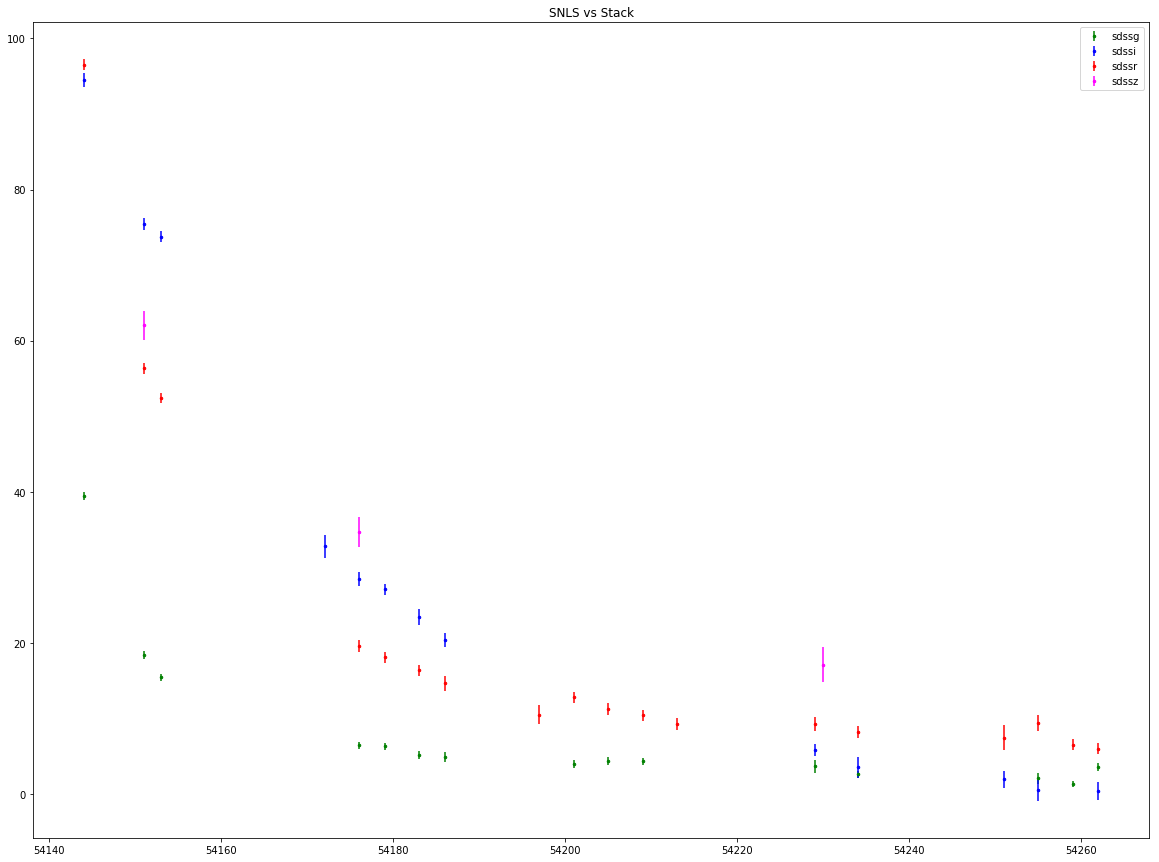

214.770852273 53.1025089601
{}


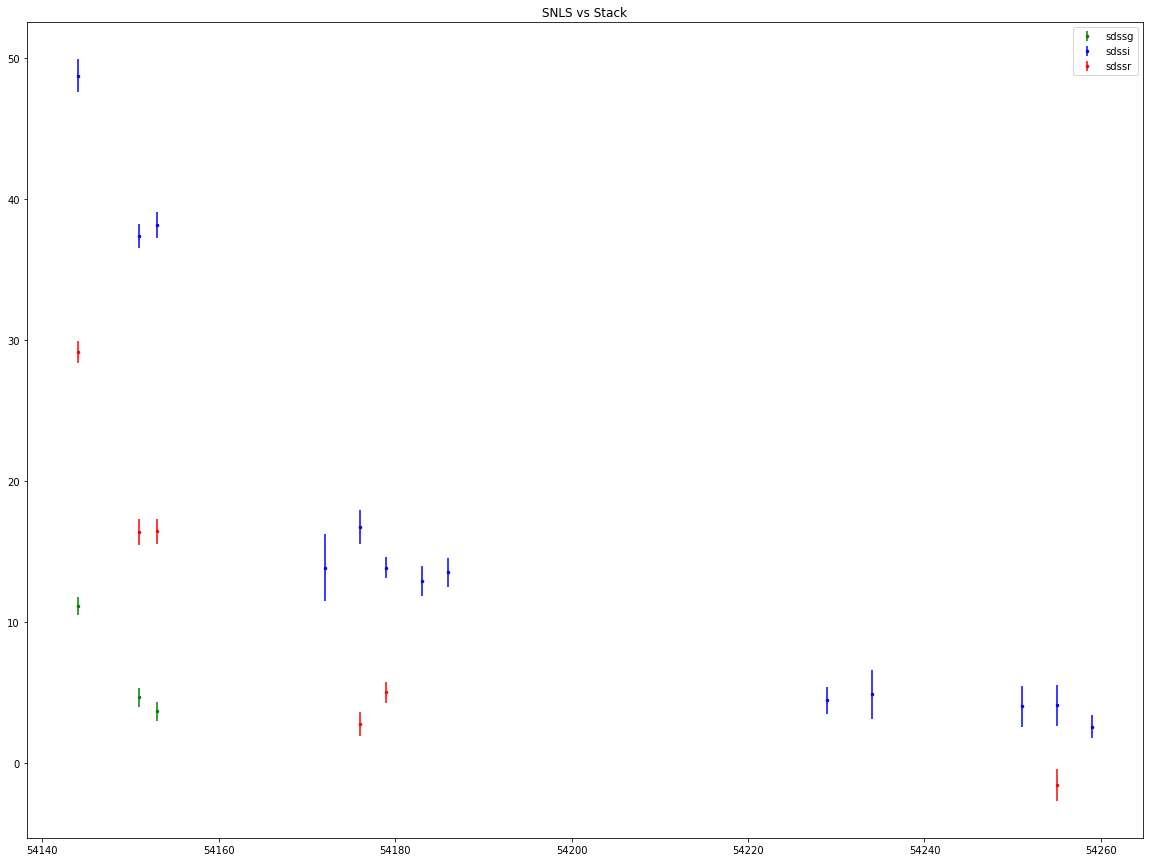

214.770847511 53.1025058164
{}


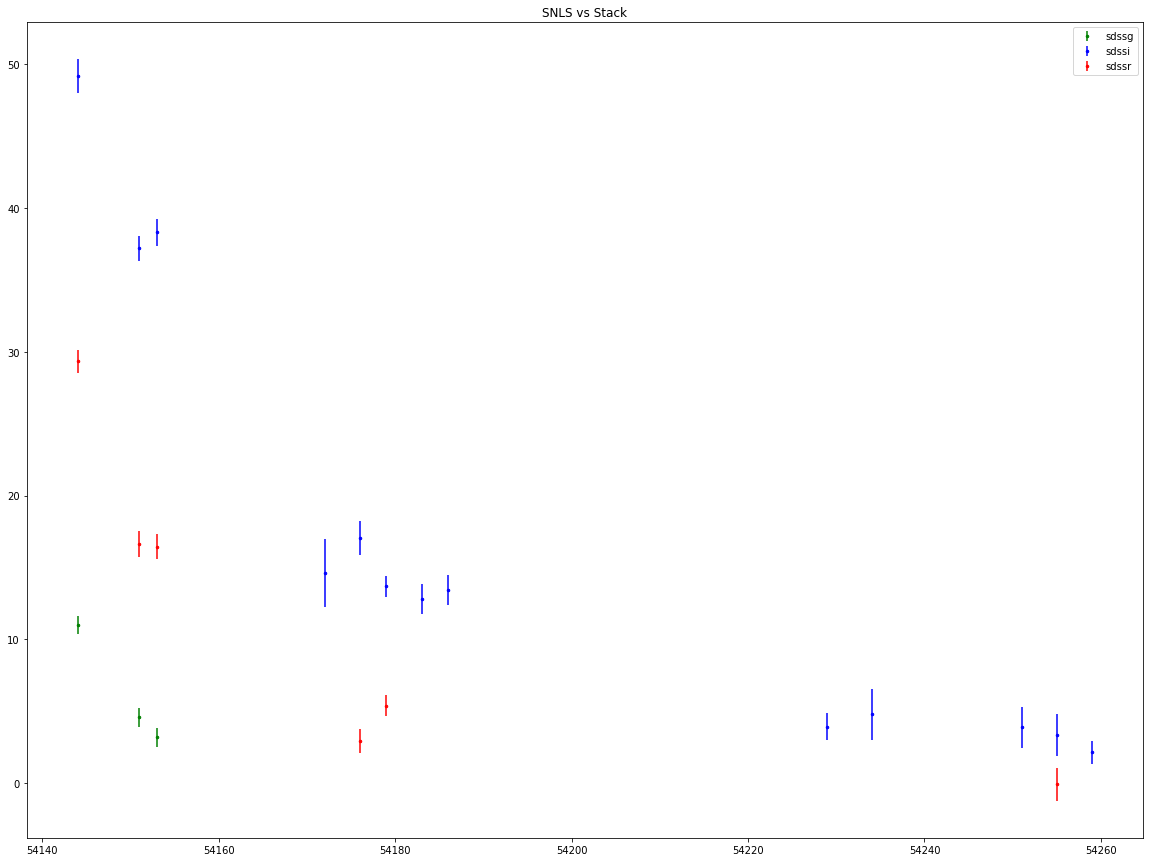

214.542769273 52.3854015148
{}


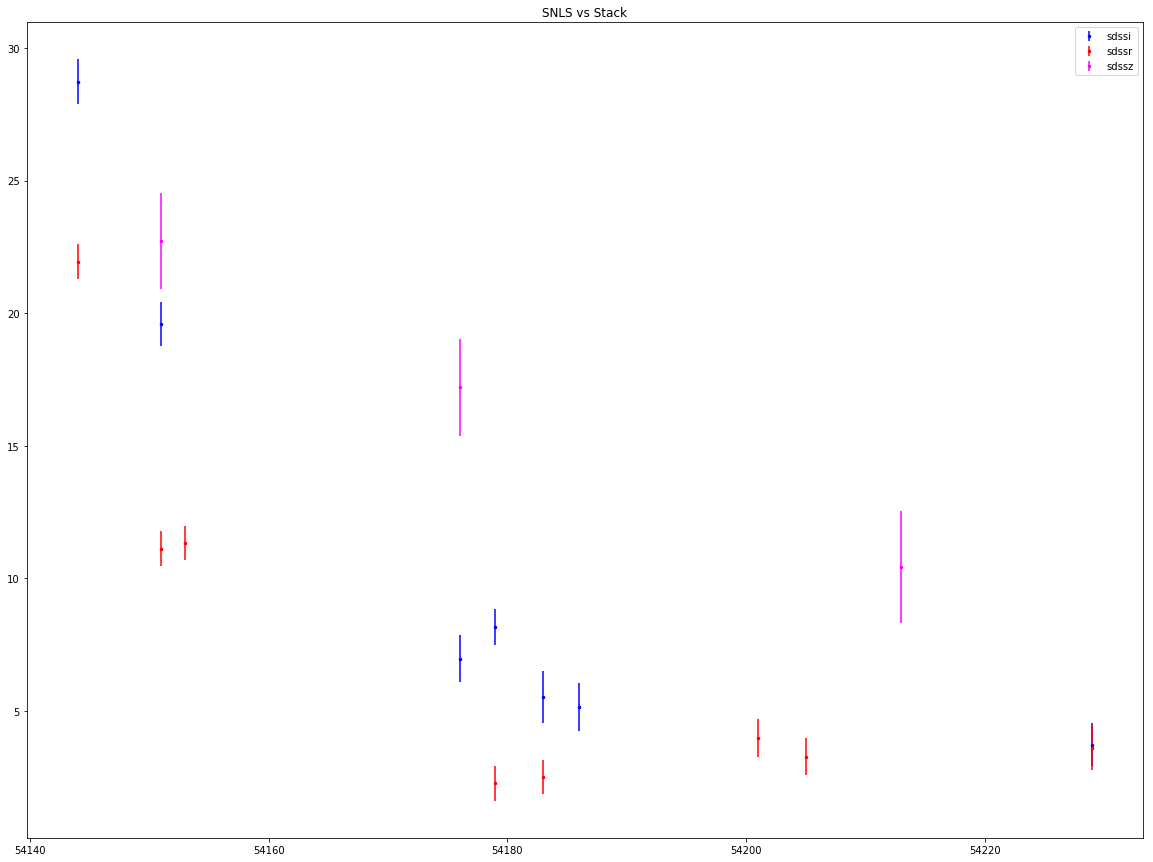

215.24333563 52.3437234155
{}


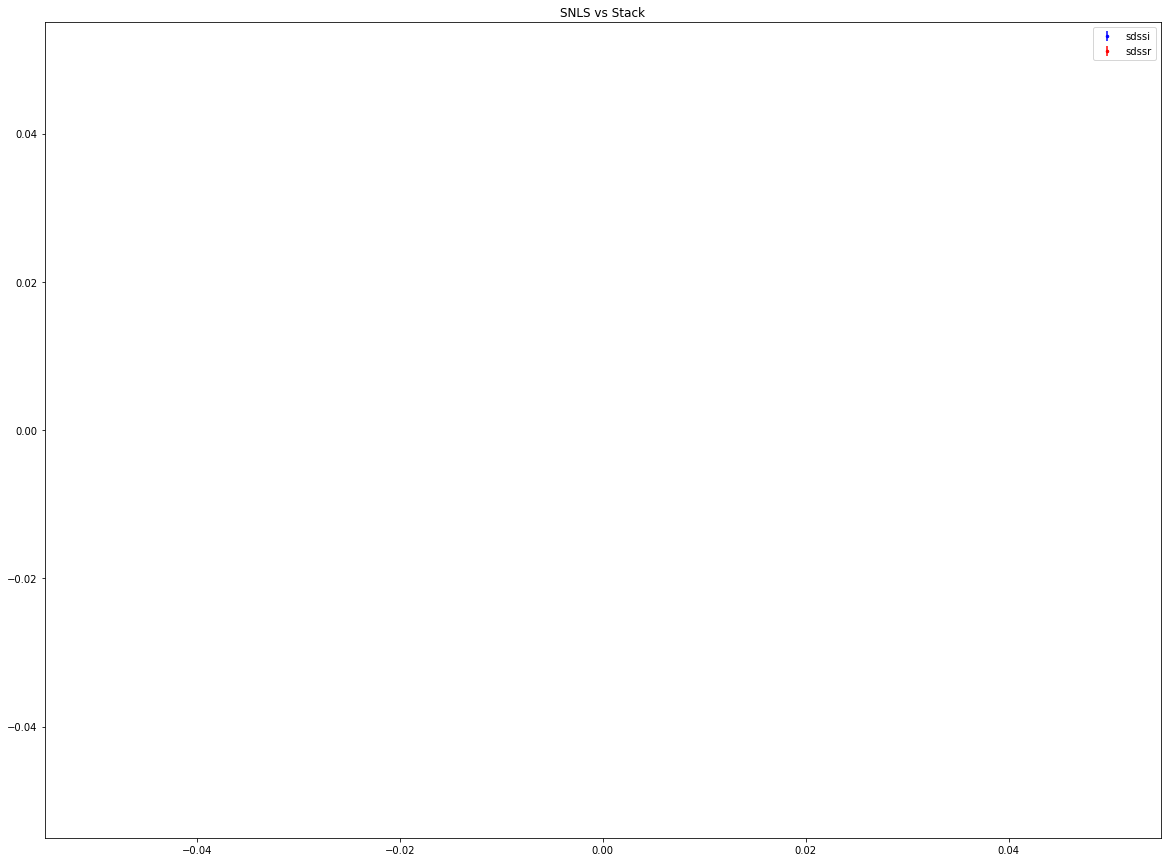

215.24333823 52.343672719
{}


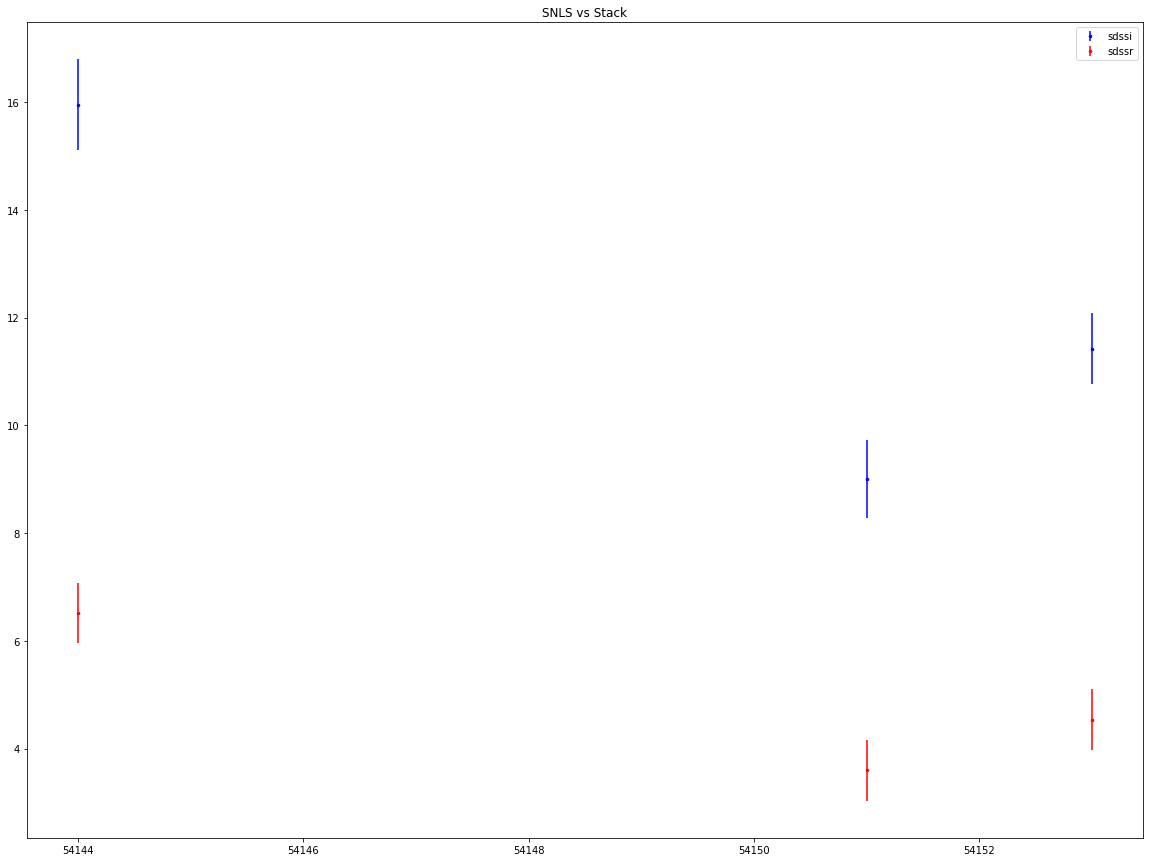

215.357164609 52.9704487216
{}


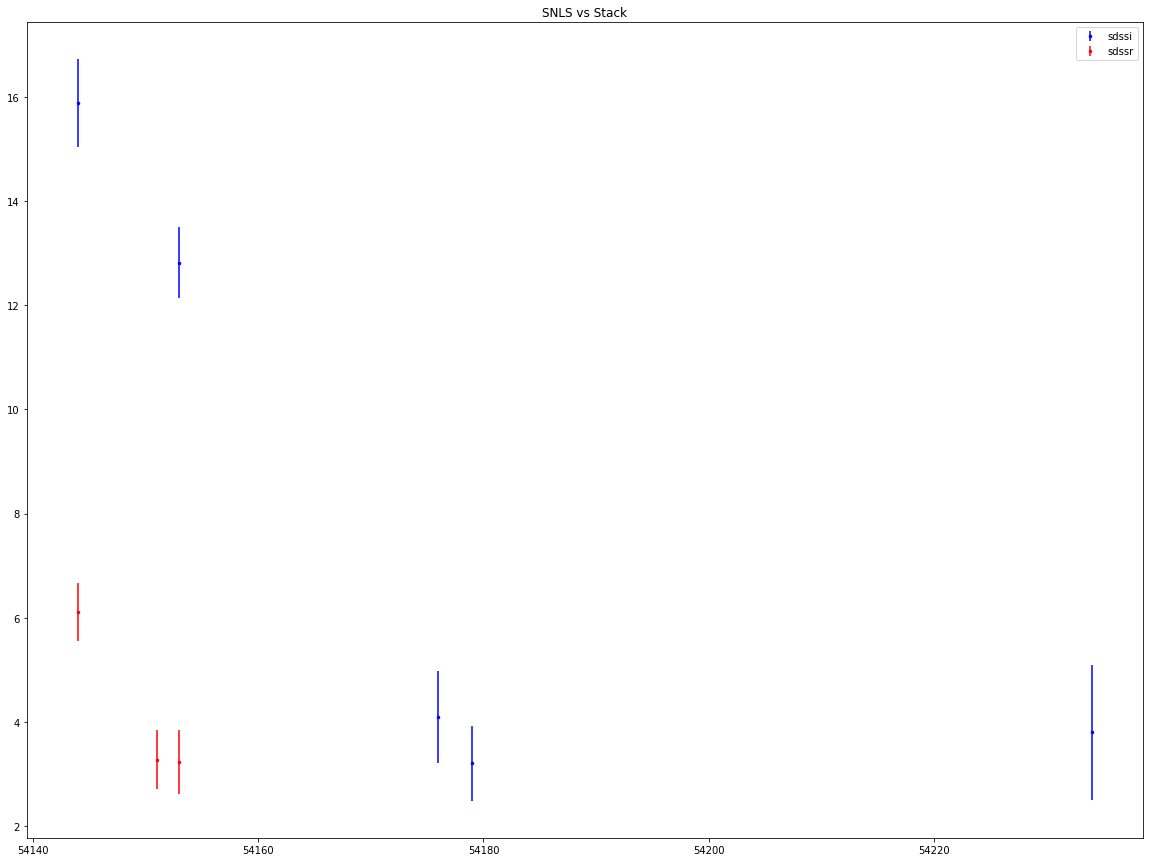

215.225470681 52.4803249859
{}


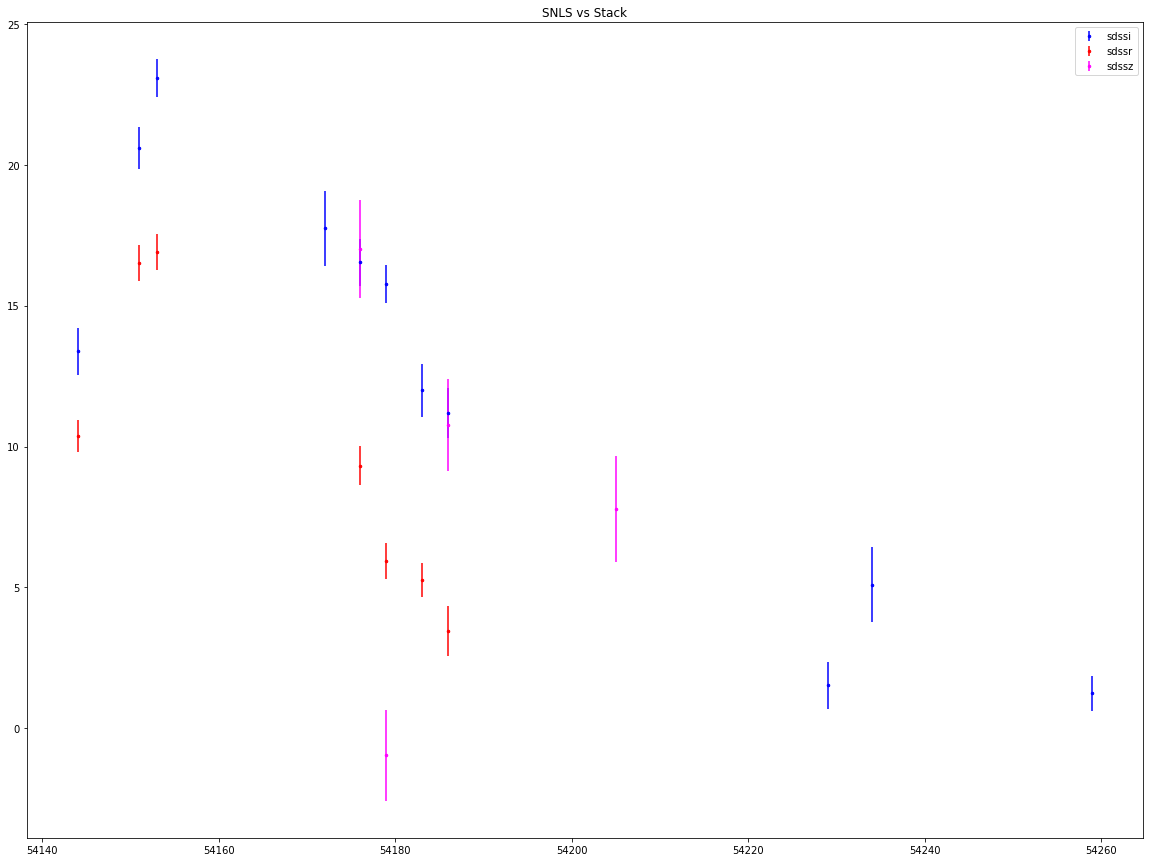

214.071843727 52.5395880024
{}


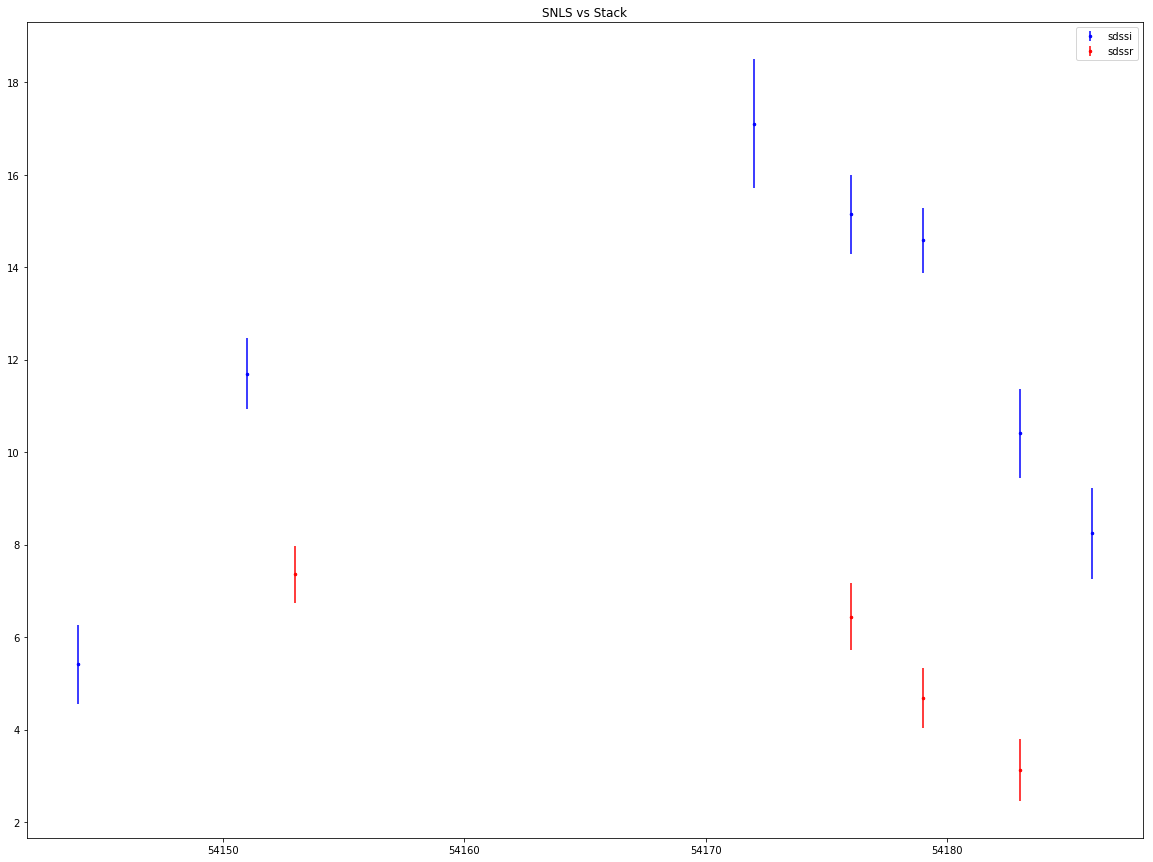

214.149531874 53.0840024418
{}


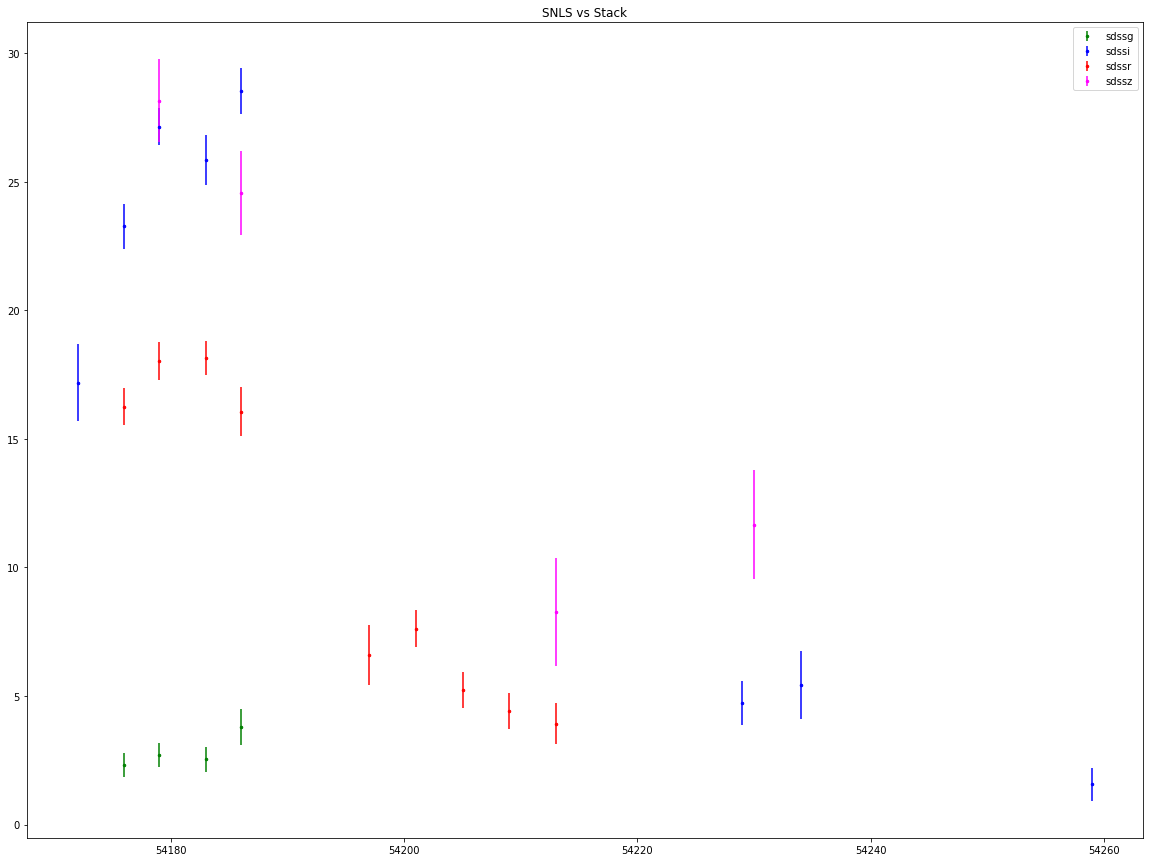

214.553450163 52.3179041883
{}


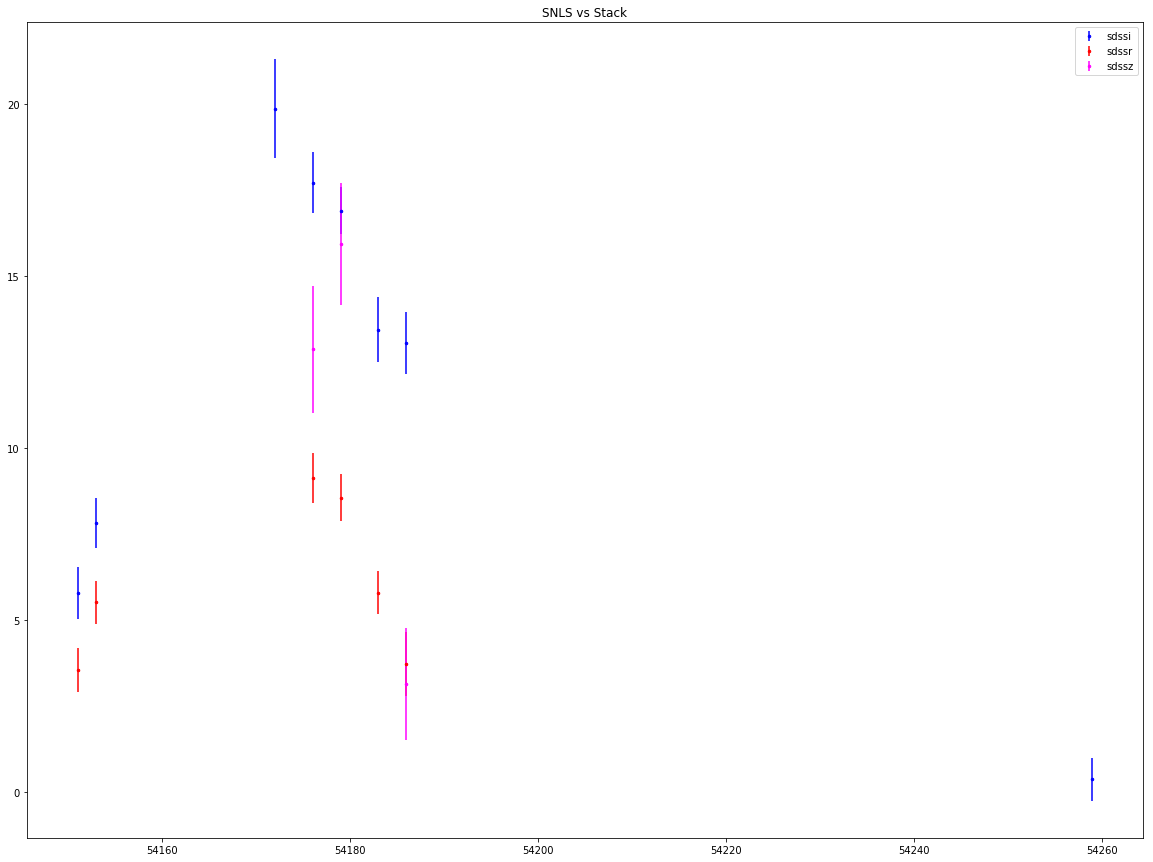

215.325949329 52.6751112187
{}


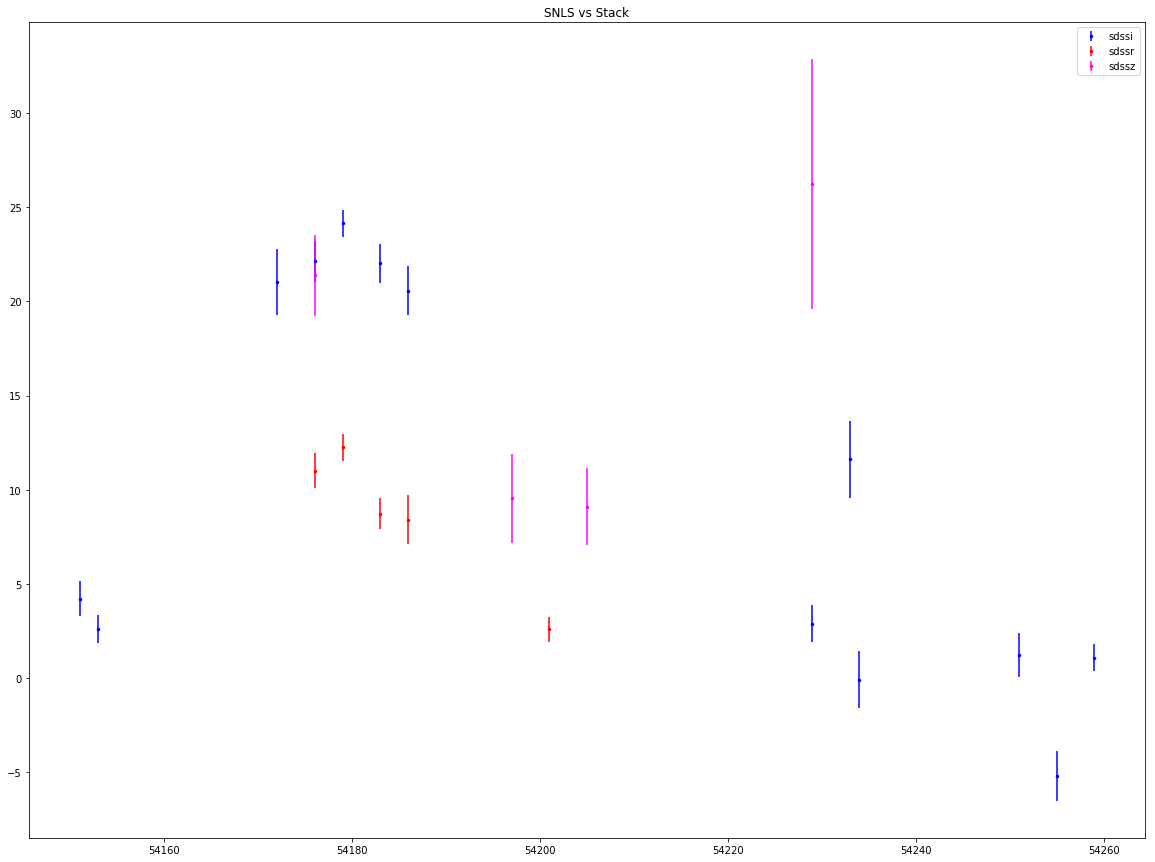

215.235490039 52.2536809977
{}


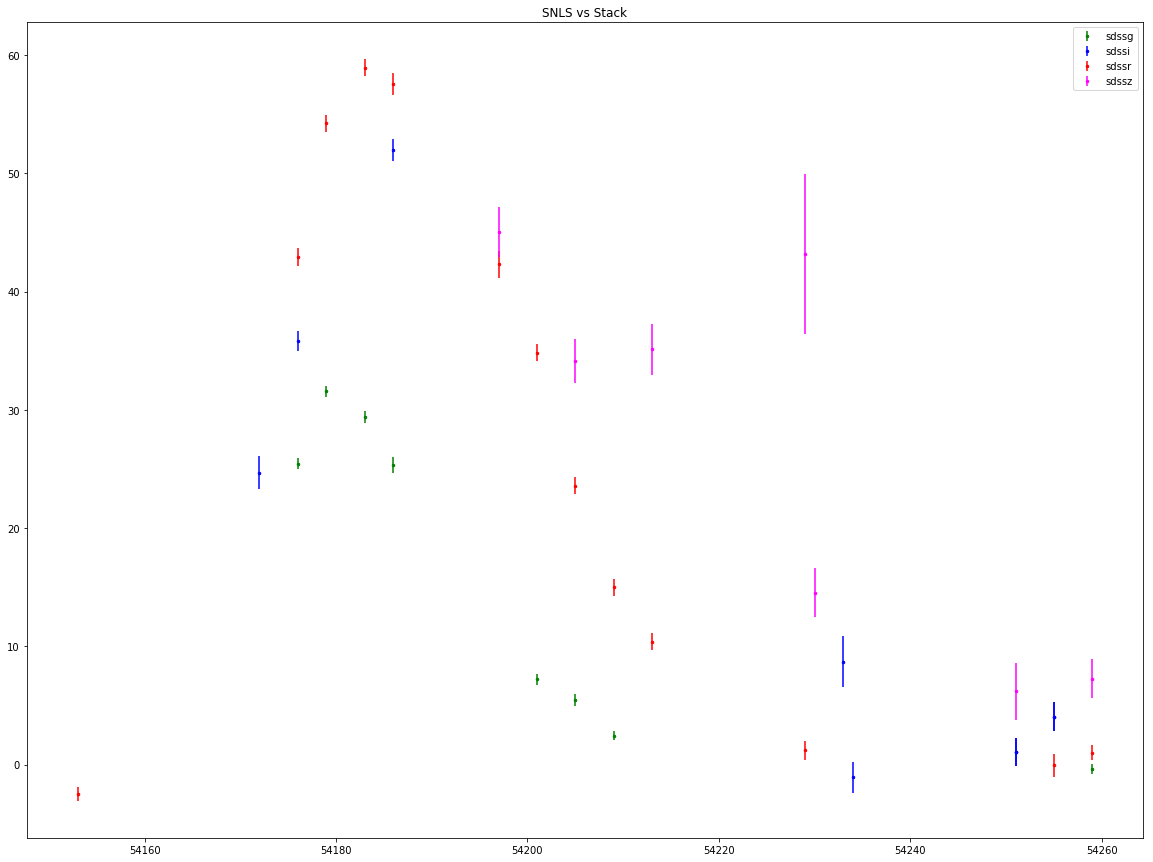

215.02591536 52.271306248
{}


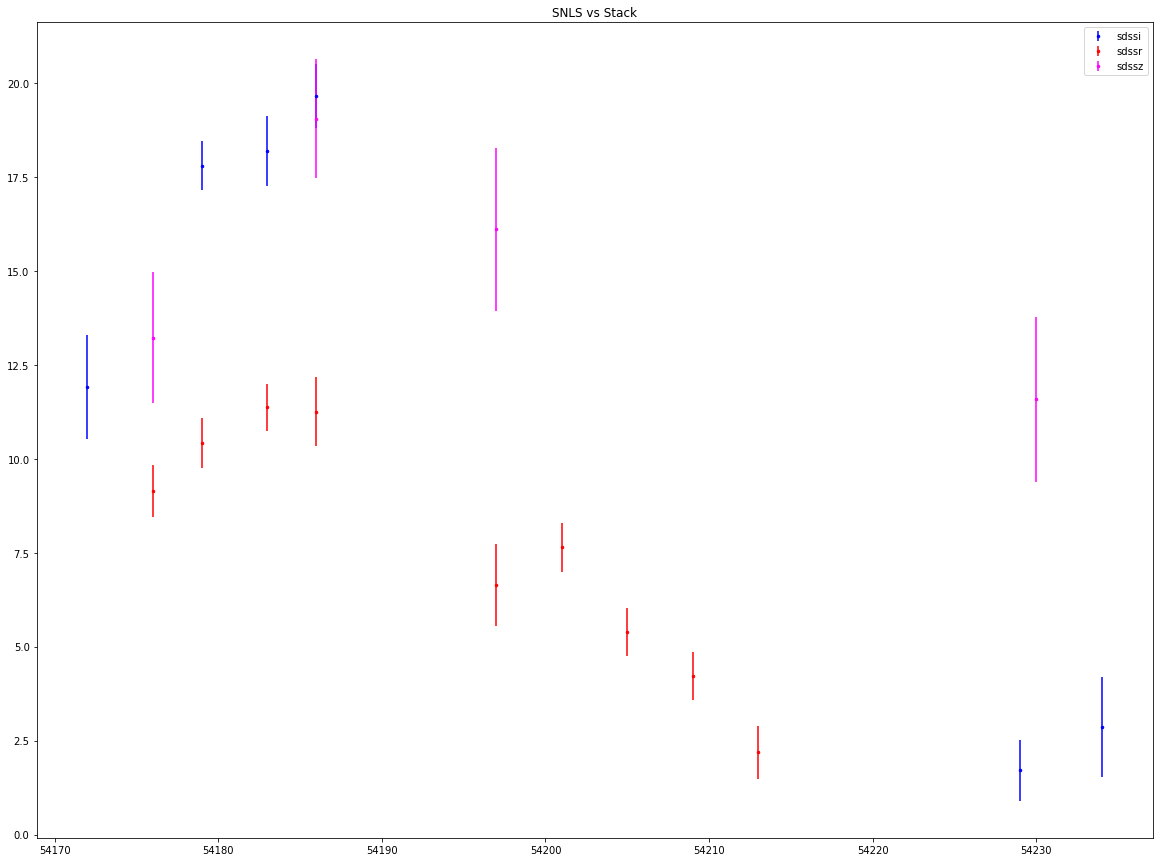

215.025936926 52.2713002257
{}


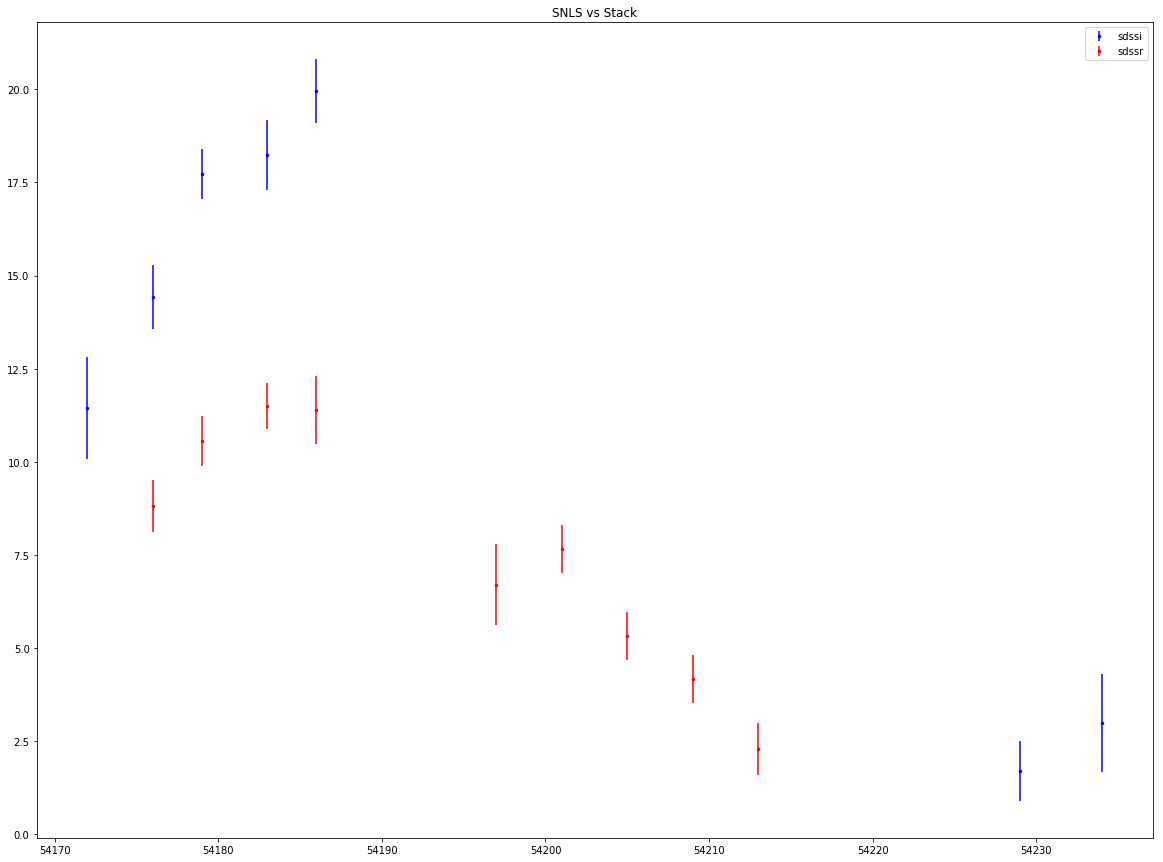

215.66997414 53.0374014335
{}


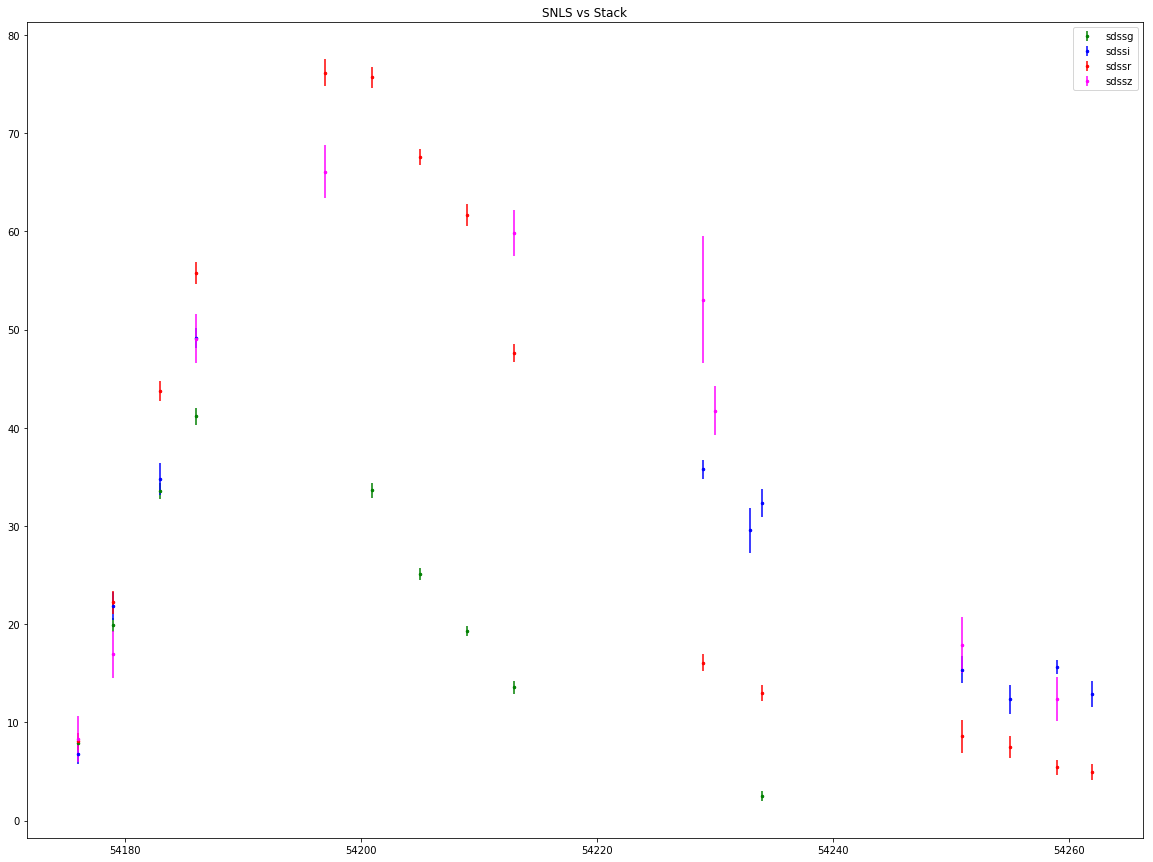

215.148676341 52.7468118563
{}


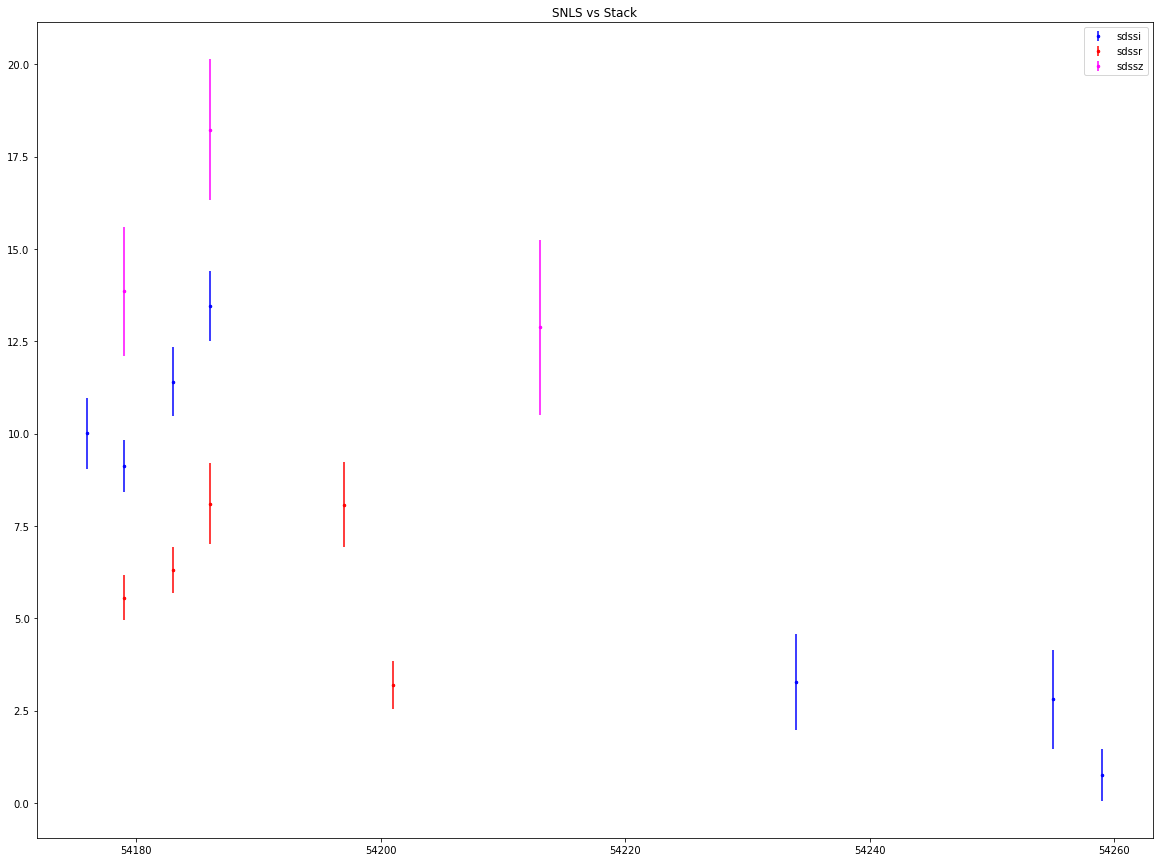

215.275497086 52.6688364473
{}


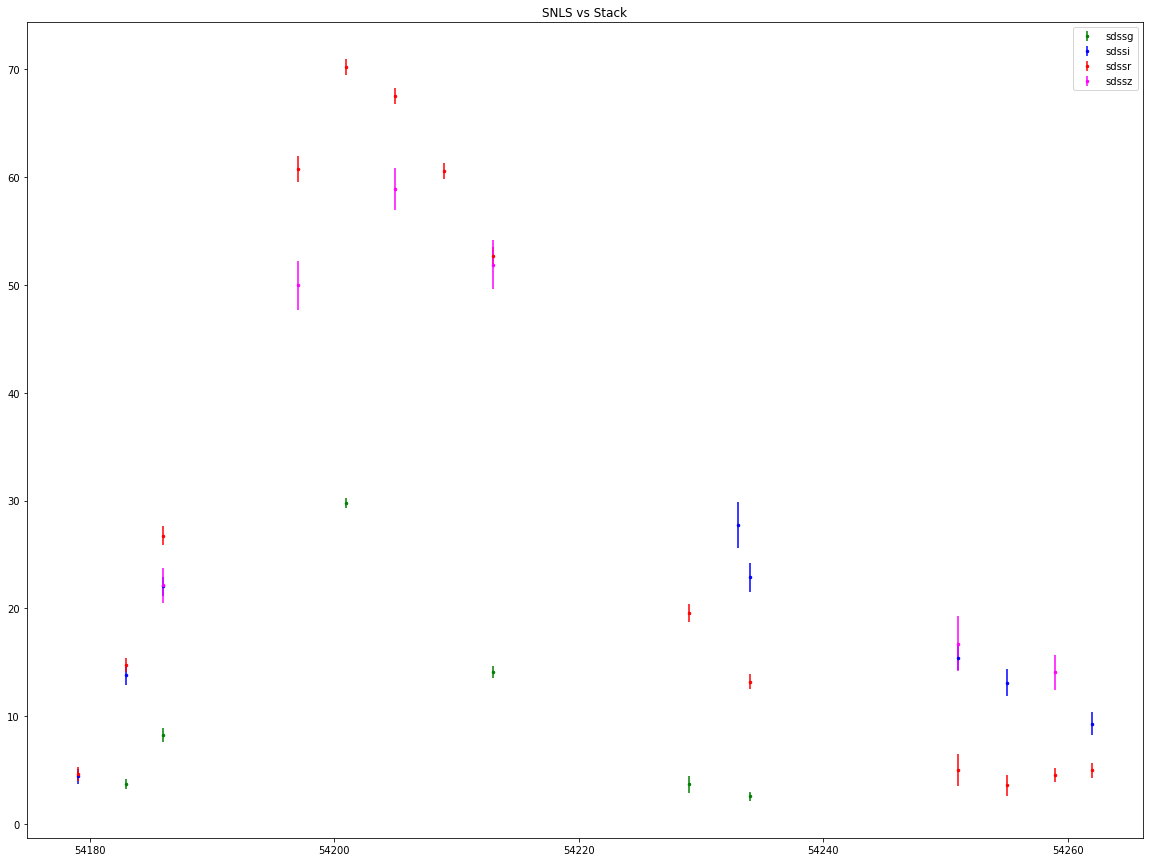

215.275495639 52.6688352853
{}


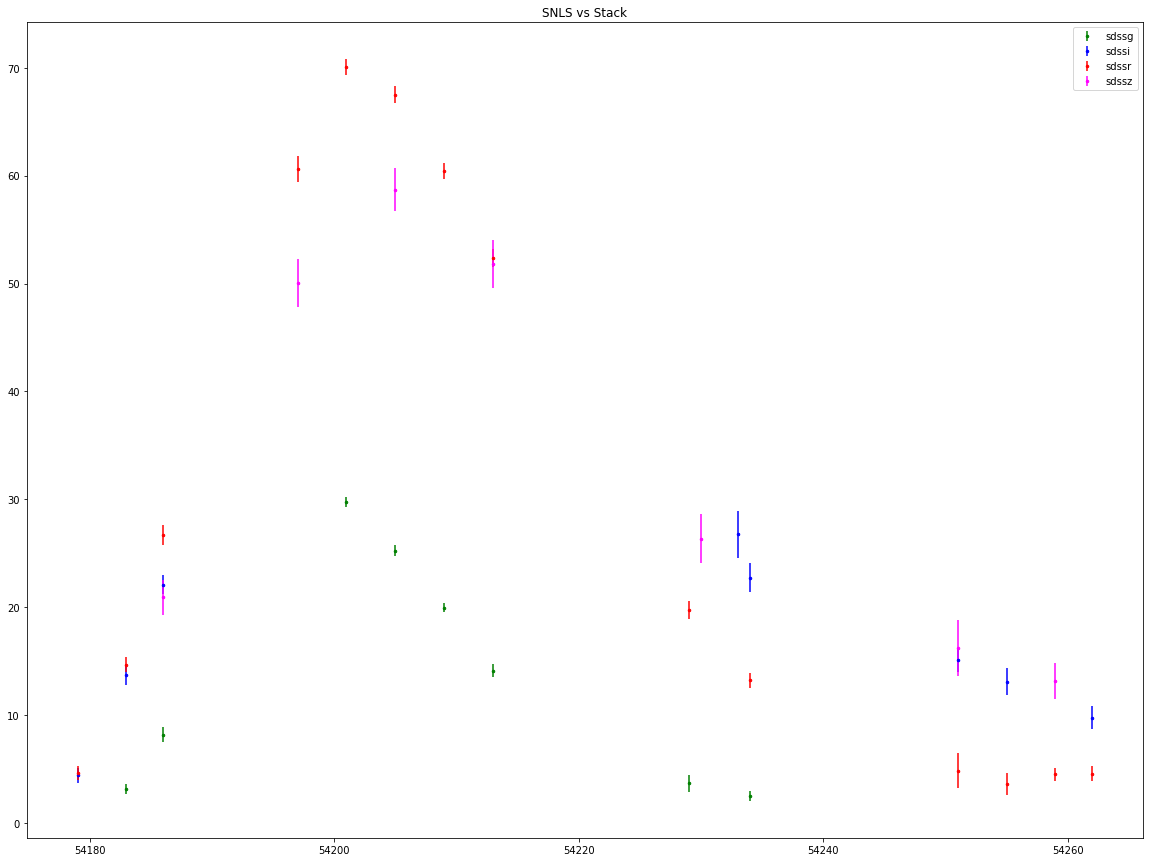

215.275497086 52.6688364473
{}


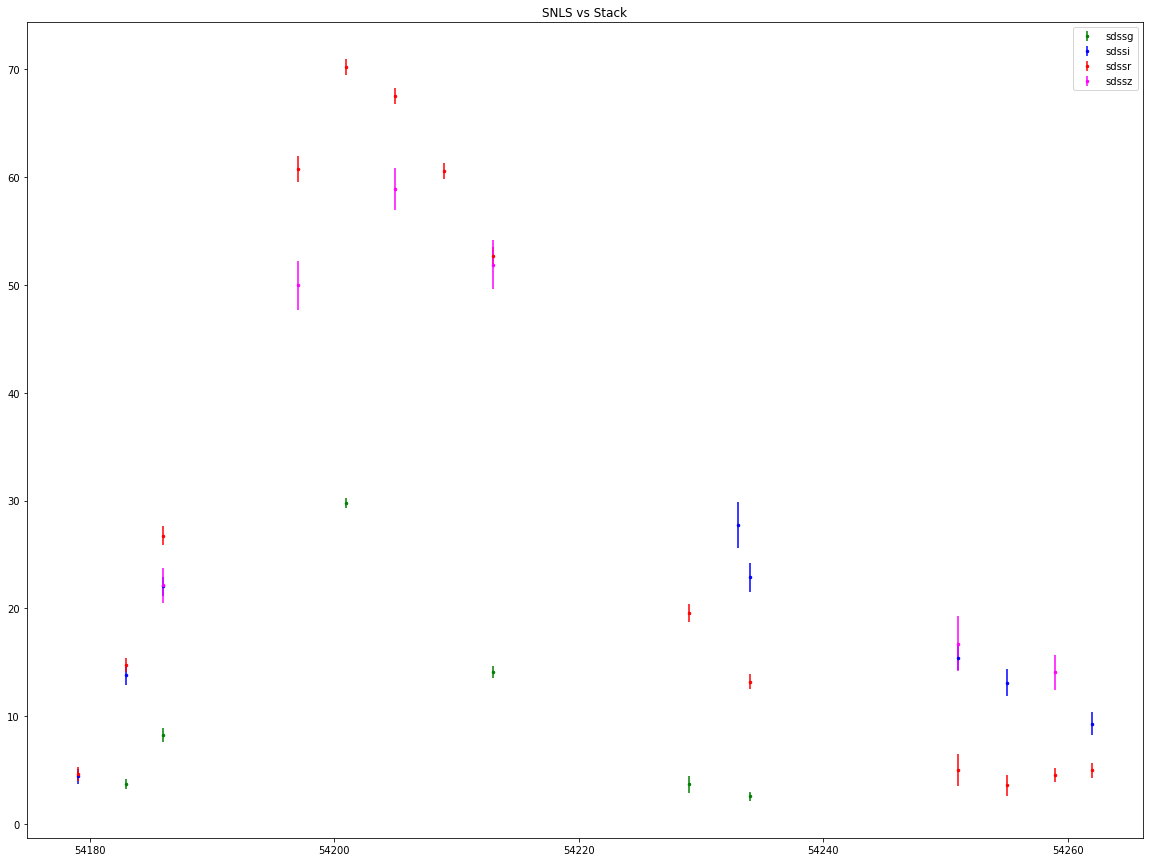

215.275495639 52.6688352853
{}


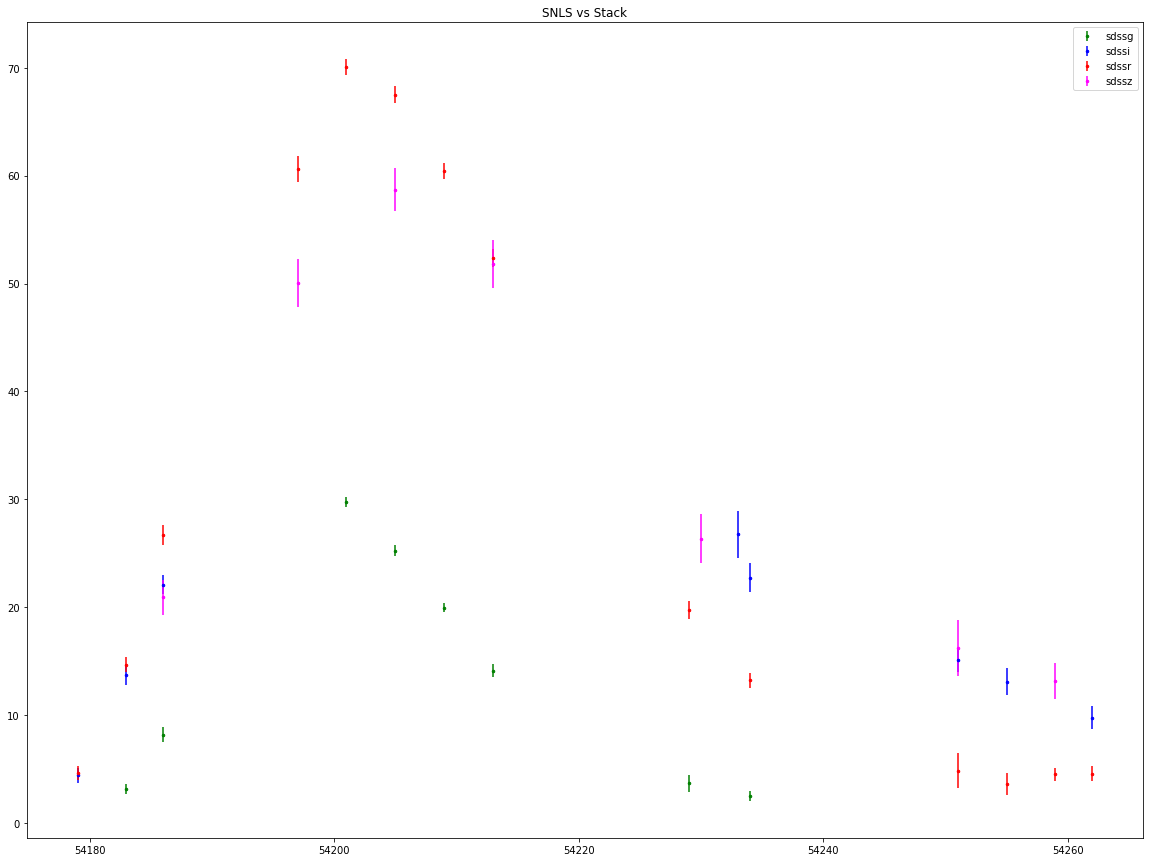

214.892115865 52.4660854178
{}


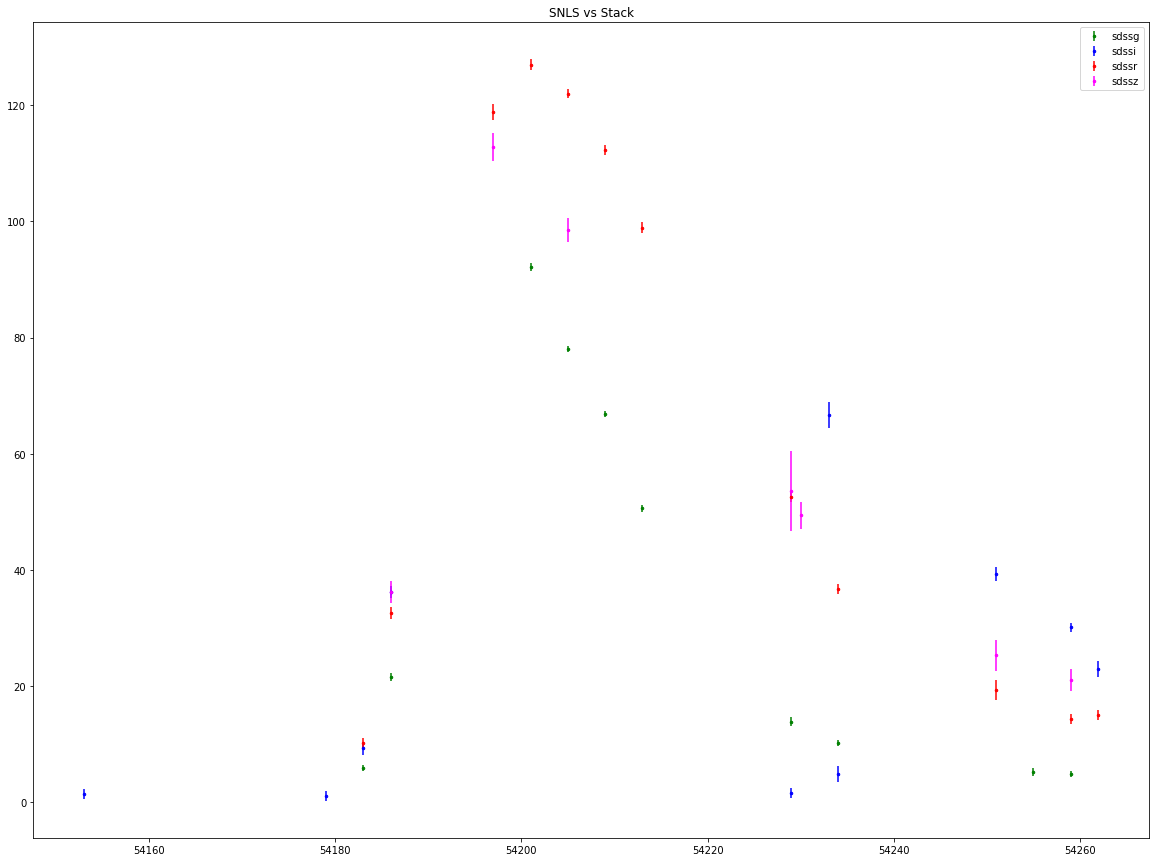

214.828936042 53.076645319
{}


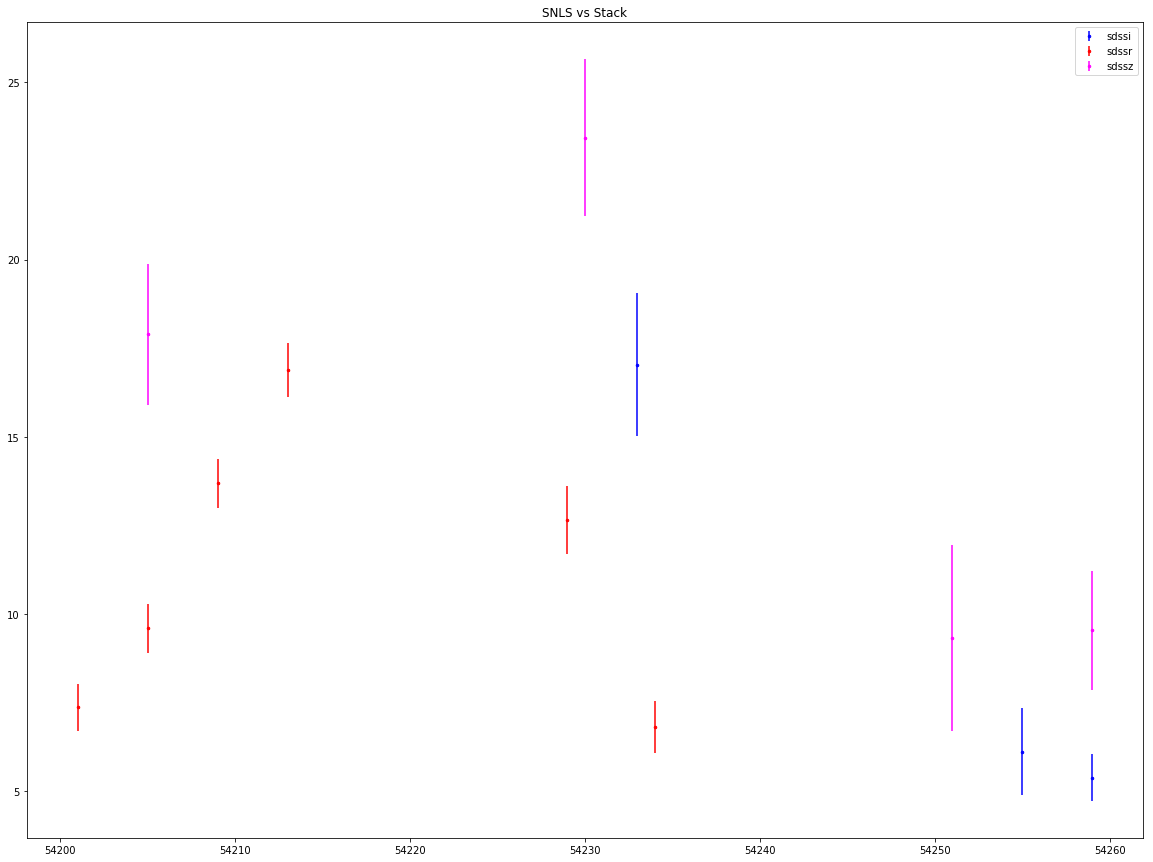

215.35331959 53.1777781448
{}


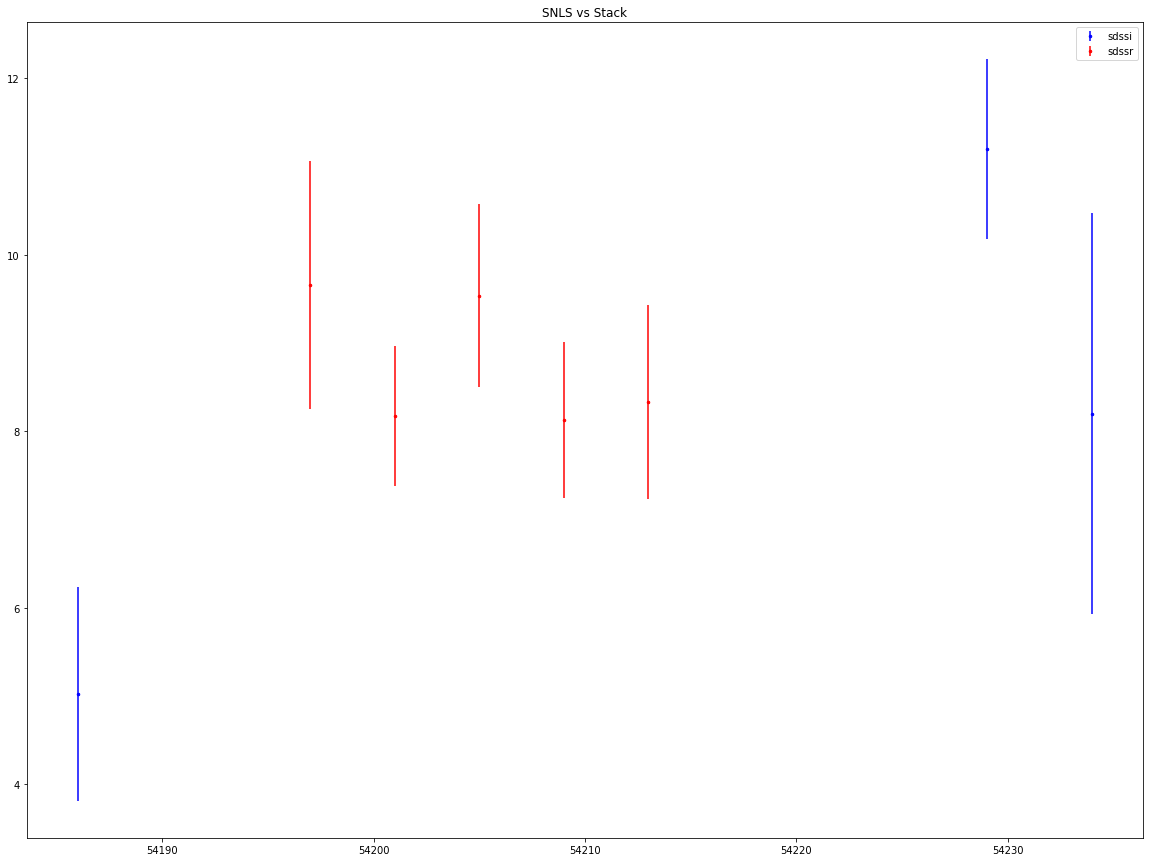

215.35331959 53.1777781448
{}


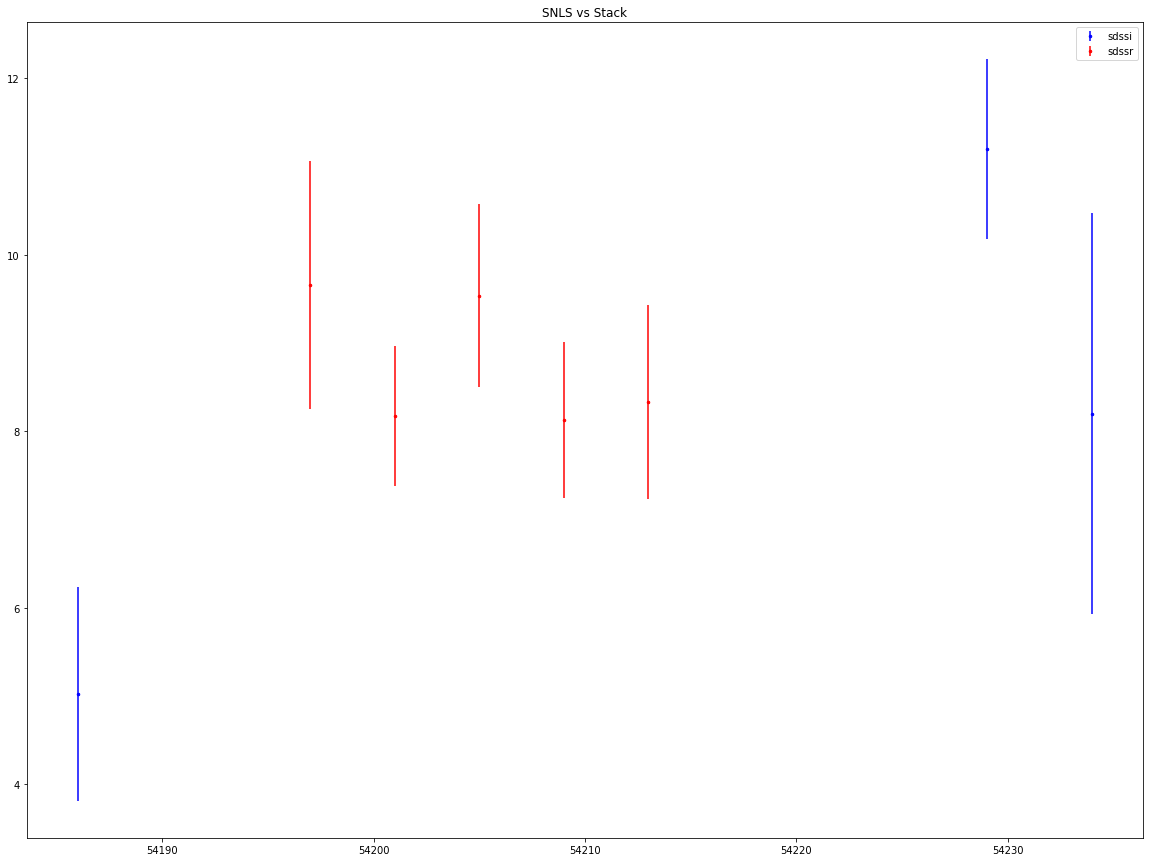

214.634651144 52.7249236555
{}


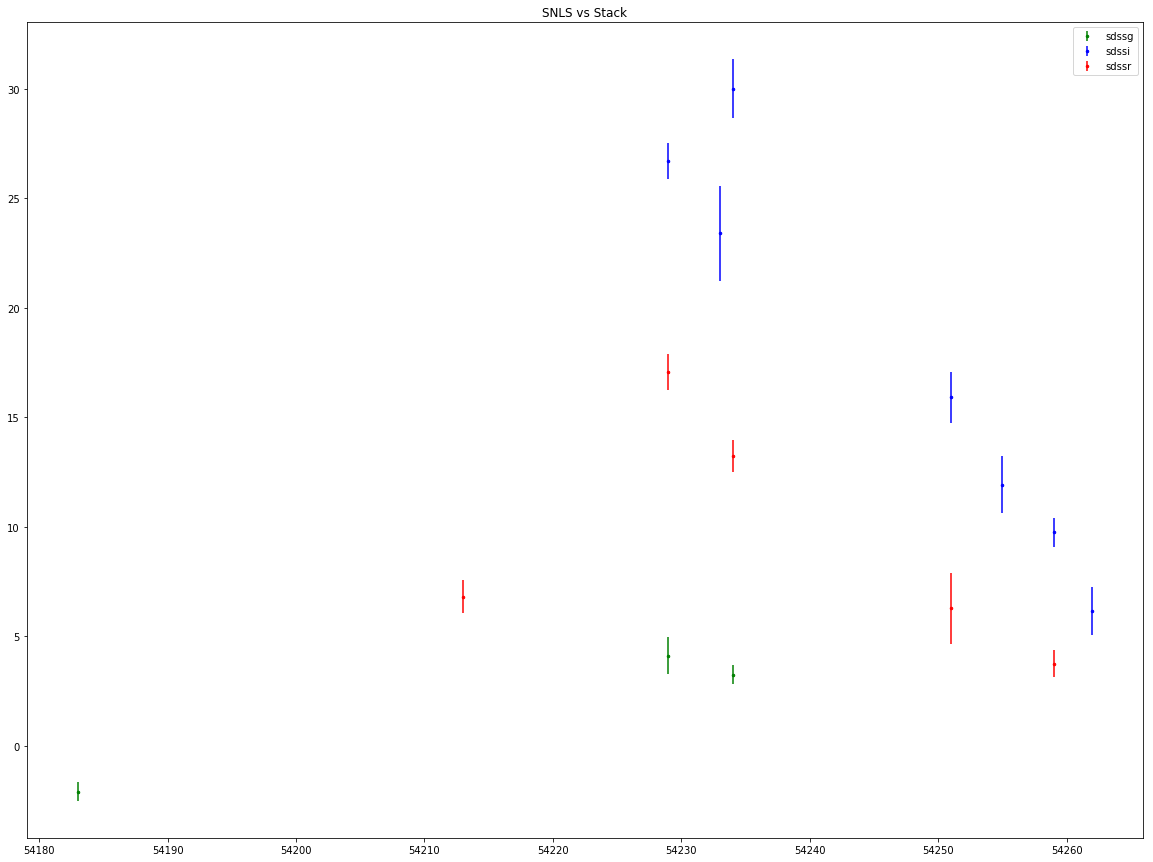

214.758663734 52.6633353468
{}


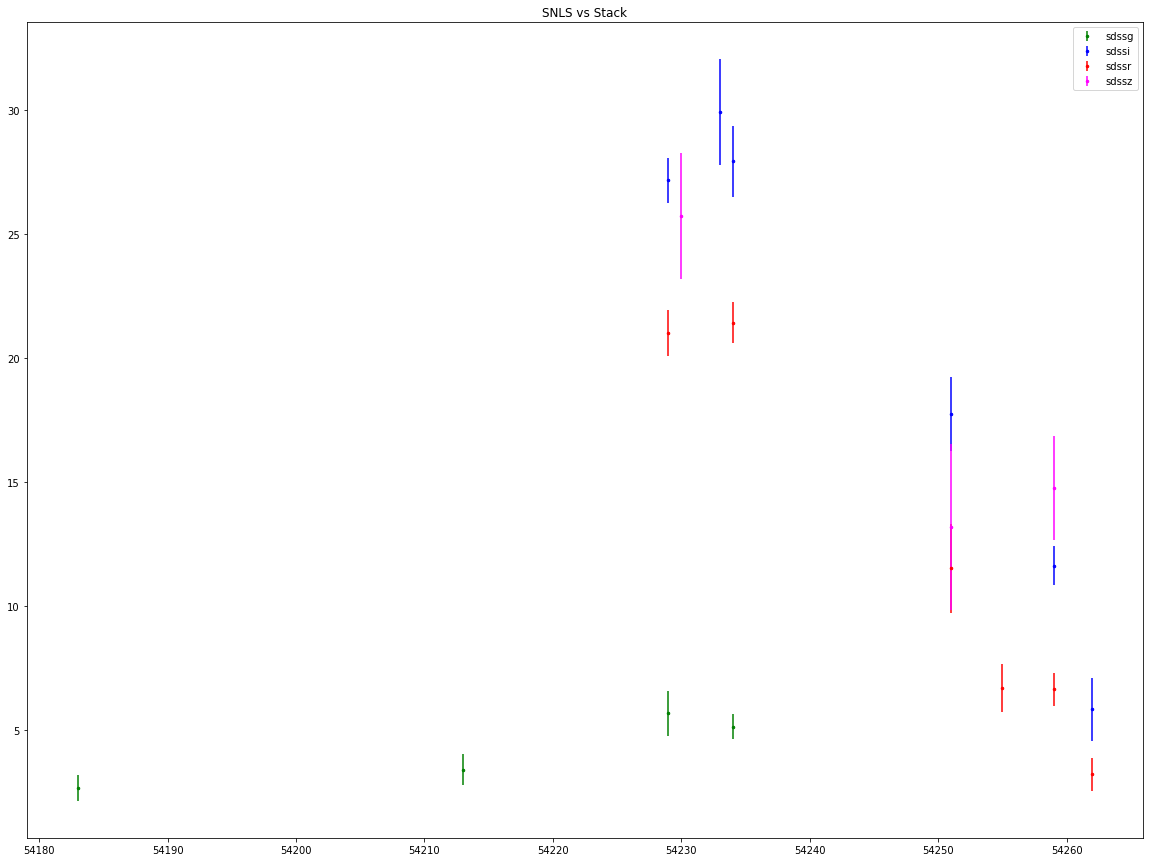

215.462070888 53.0995720937
{}


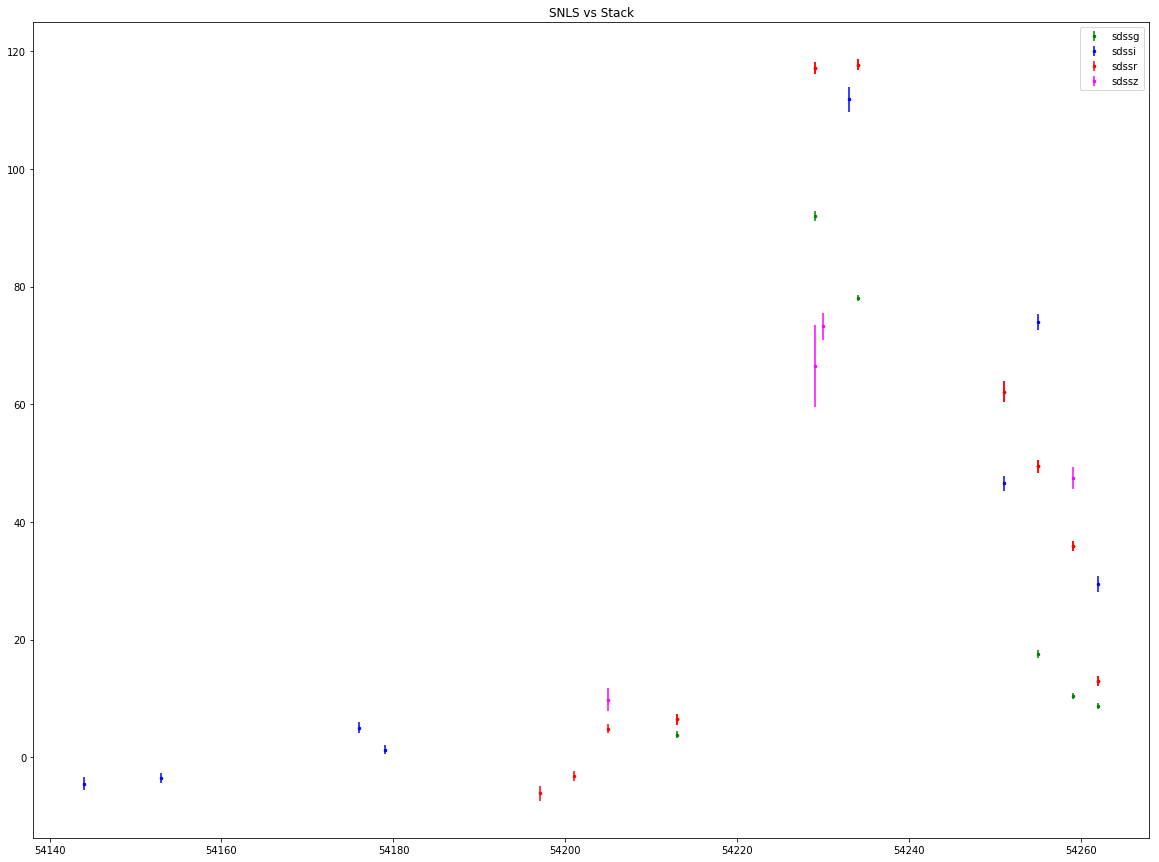

214.10474068 53.1426633295
{}


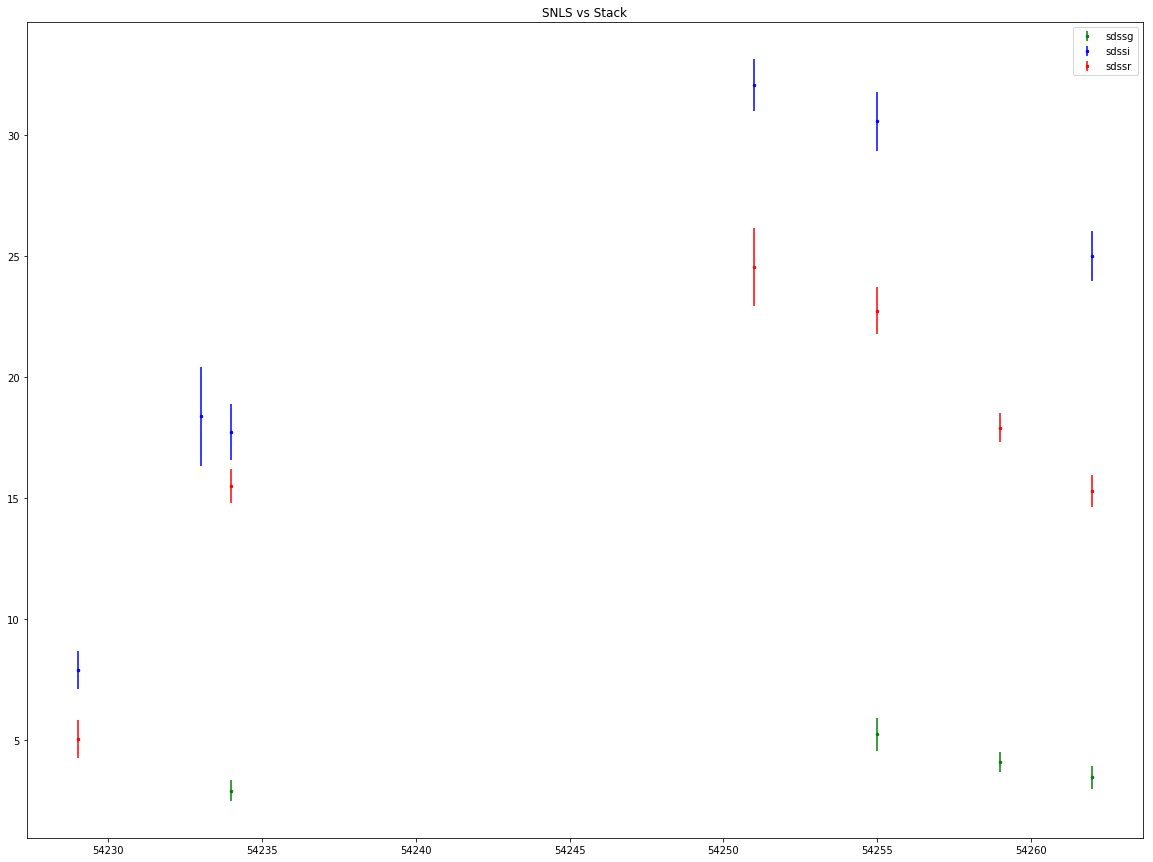

215.310674475 52.7981645758
{}


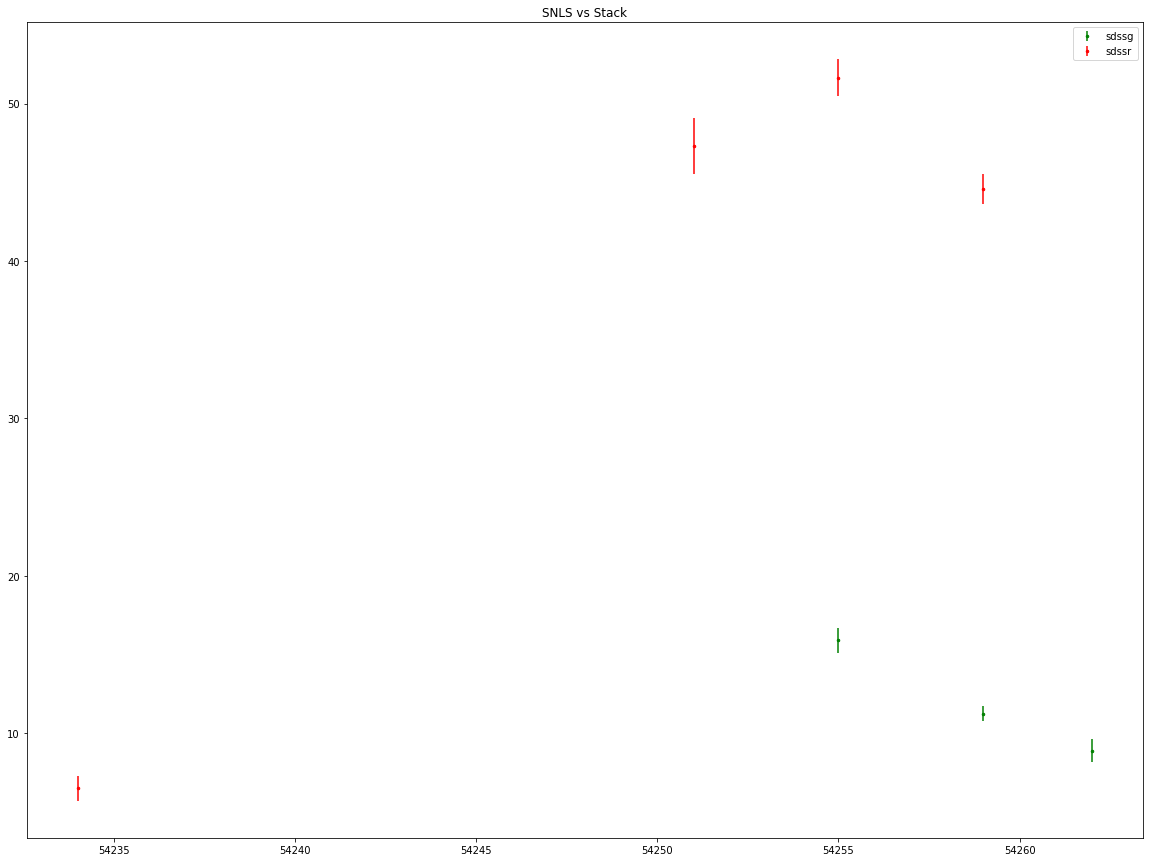

215.274811489 52.8934467586
{}


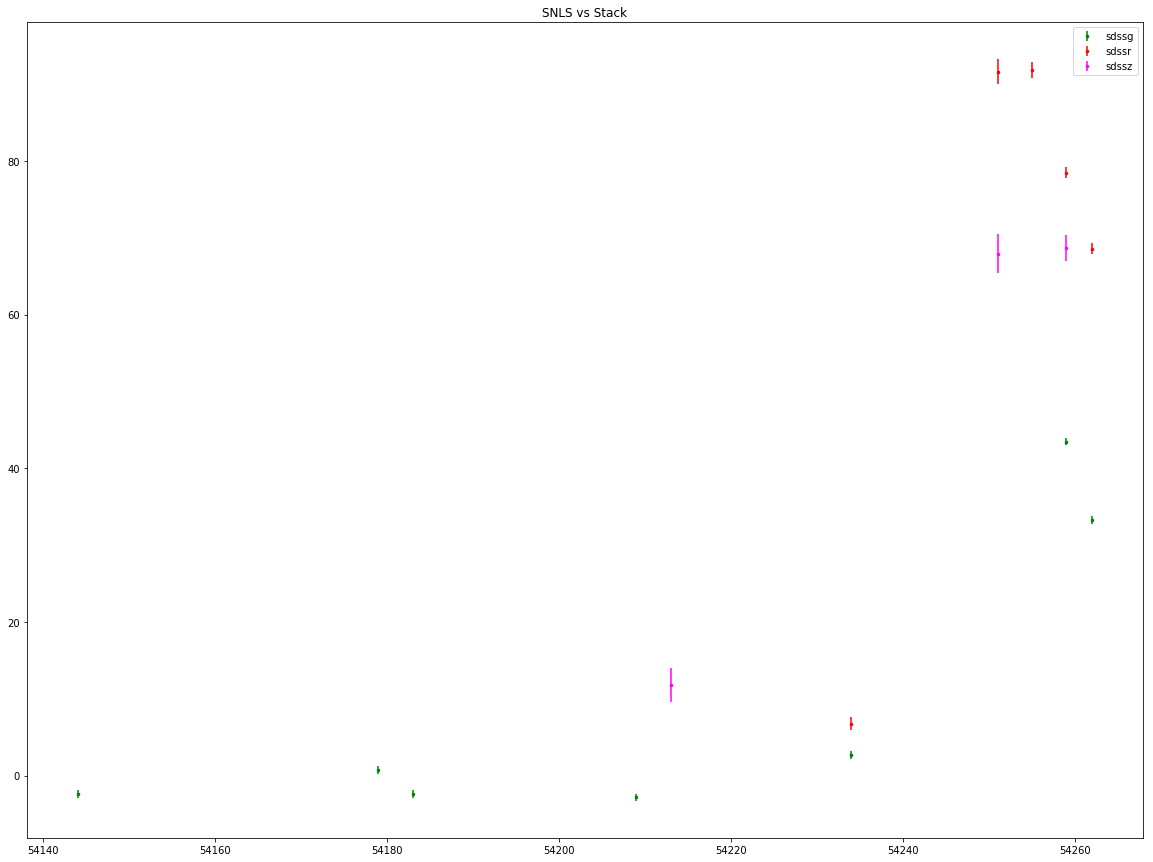

215.274773737 52.8934756475
{}


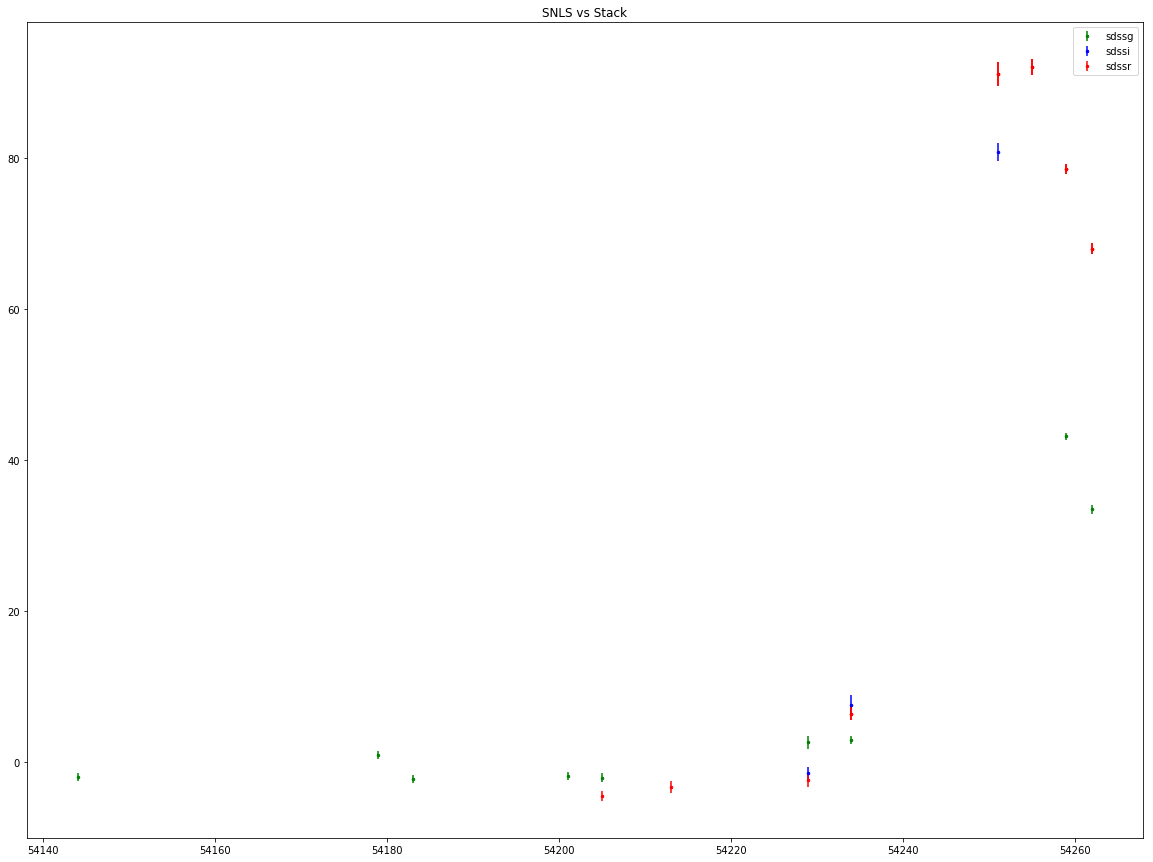

215.451754261 52.5093595672
{}


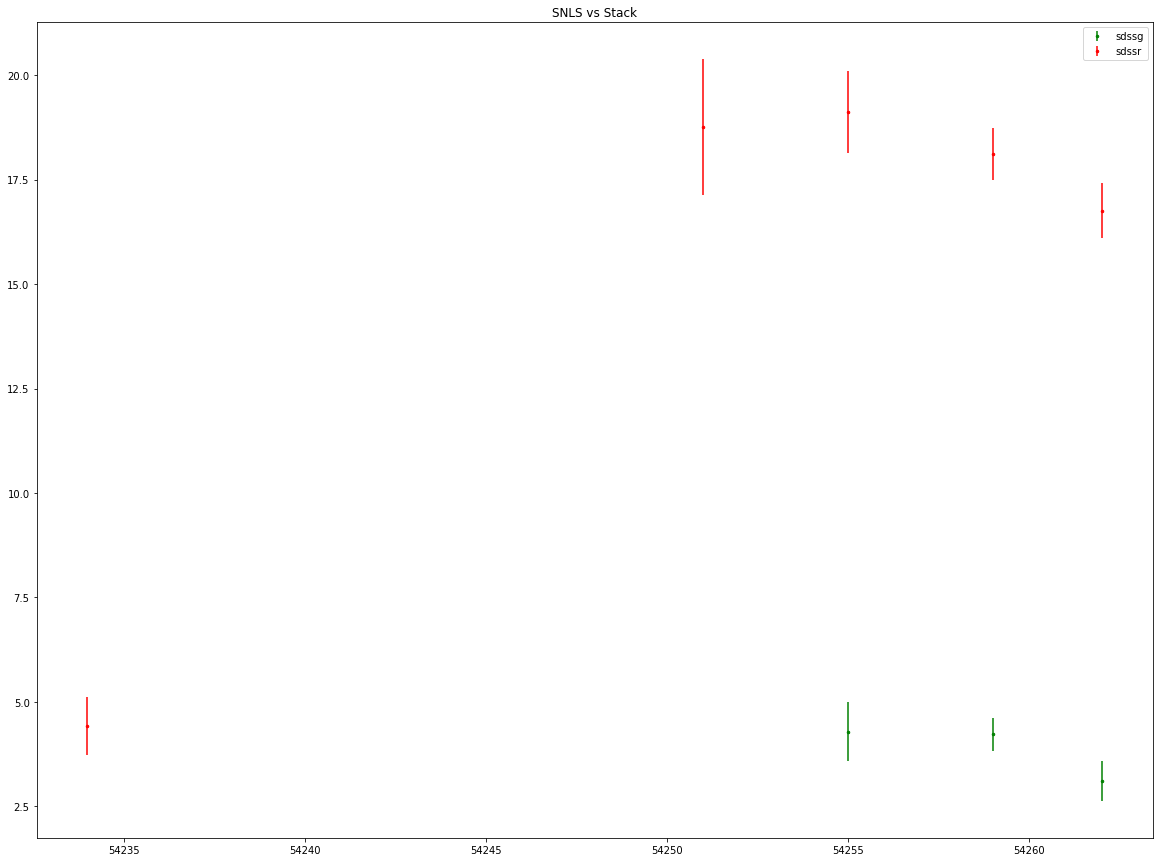

215.451760651 52.5093547311
{}


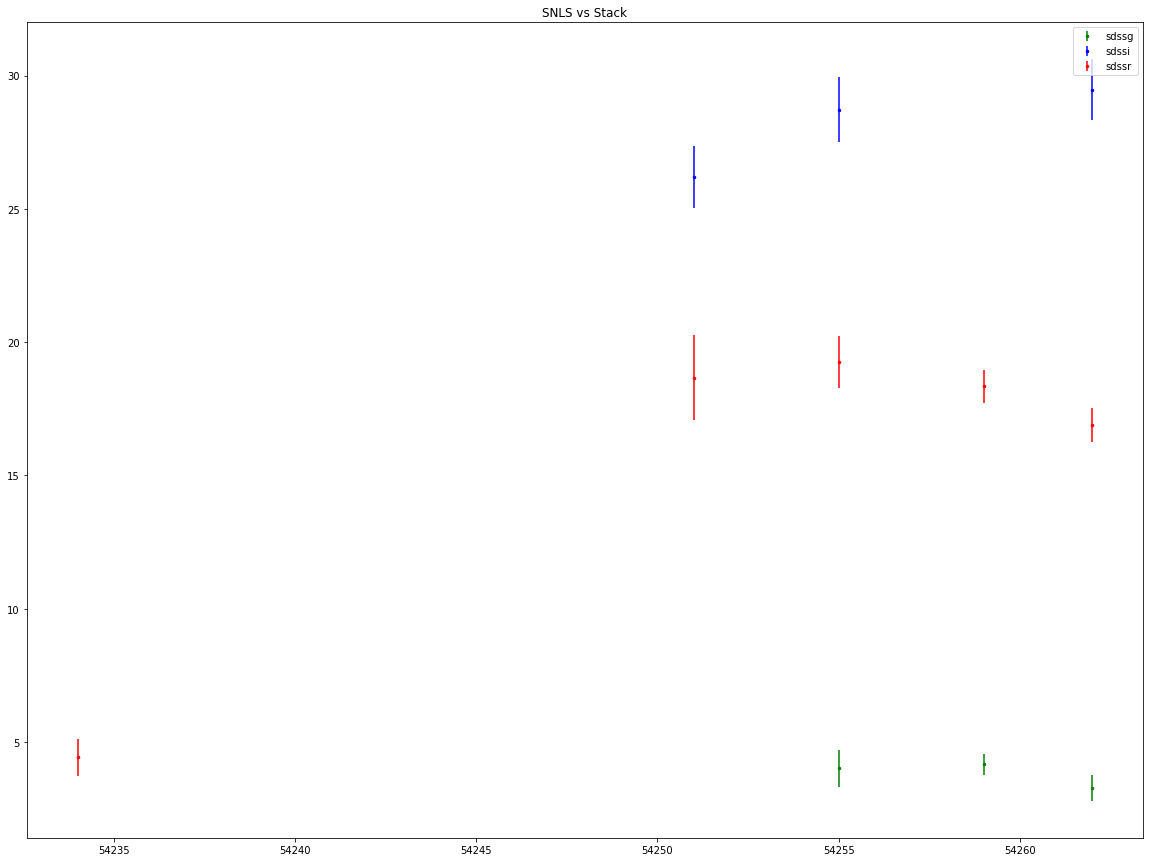

215.123178172 52.3991208421
{}


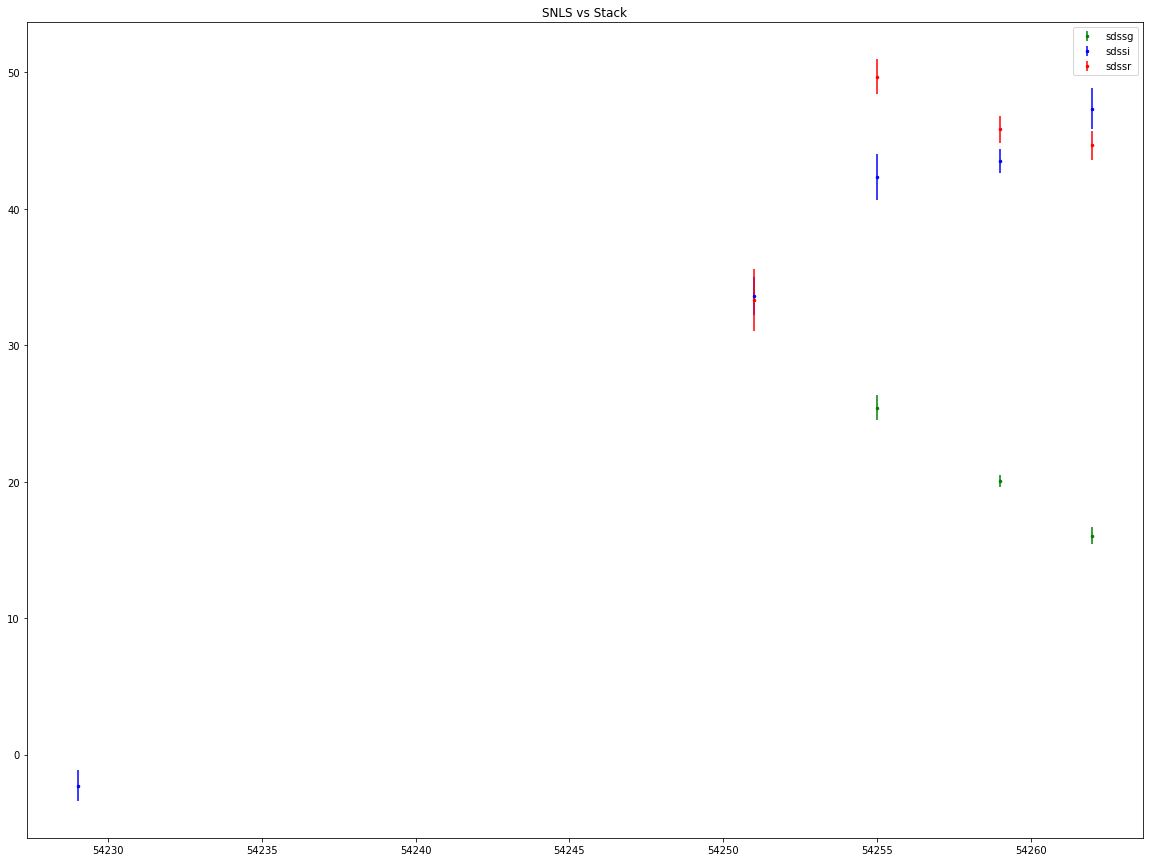

215.123177208 52.3991226087
{}


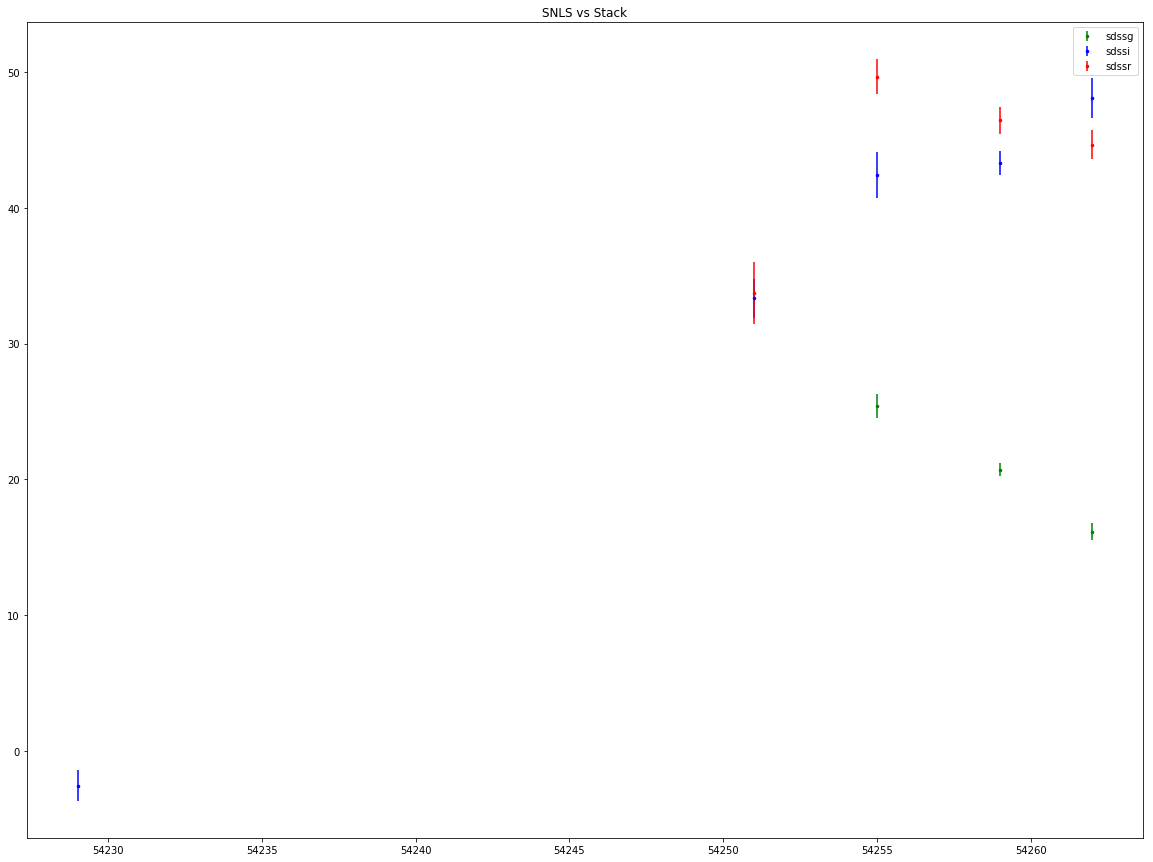

214.294947726 53.0796883575
{}


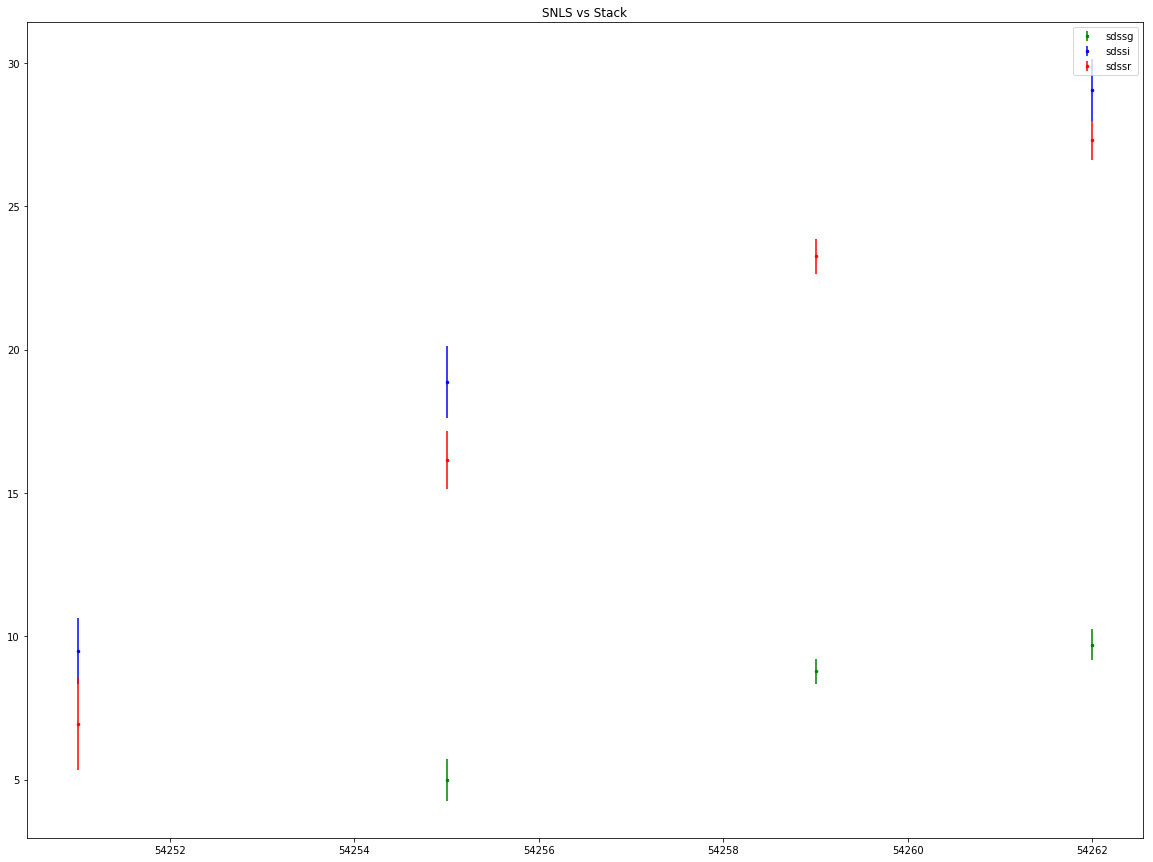

214.536322698 52.4178047369
{}


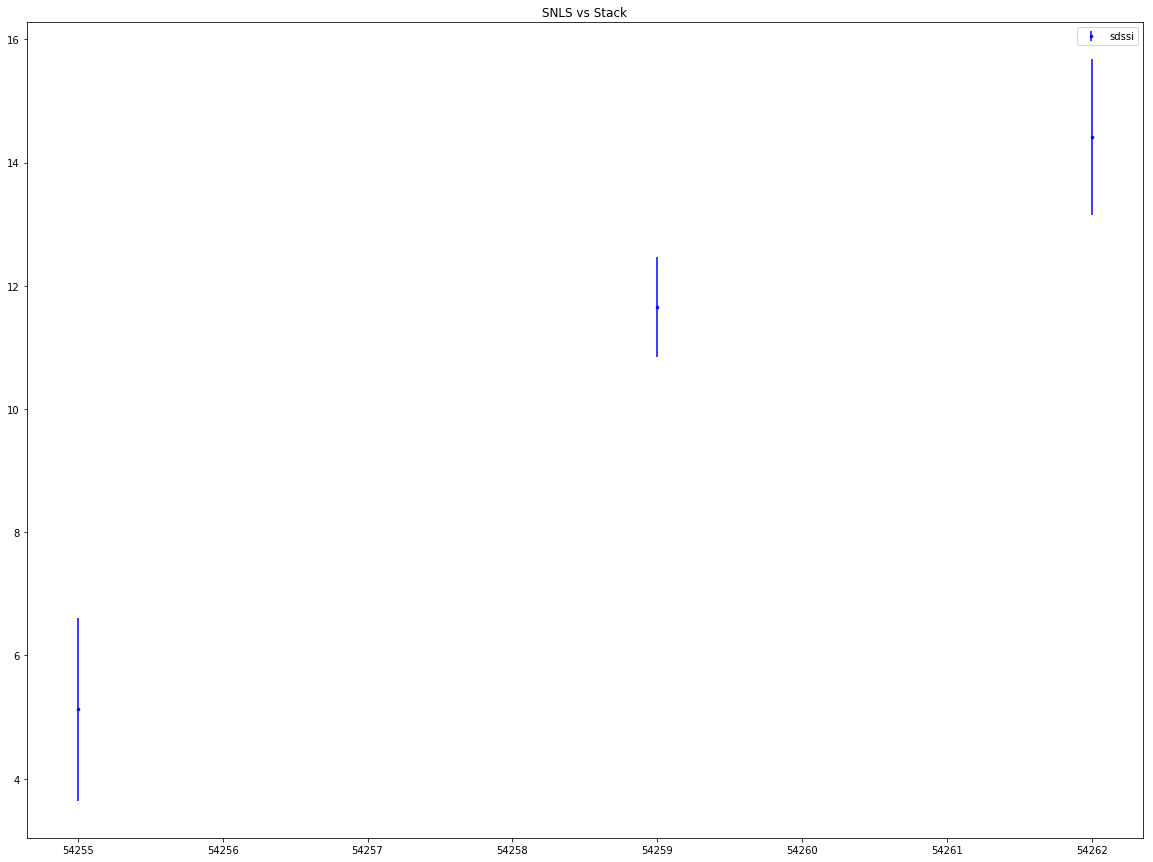

In [52]:
for match in matches_45:
    t = match[-1]
    

    plt.figure(figsize=(20,15))
    c = coord.SkyCoord(ra=float(np.mean(t['ra'])), dec=float(np.mean(t['dec'])), unit=(u.rad))
    print c.ra.deg, c.dec.deg
    
    #plt.subplot2grid((2, 2), (0, 0), colspan=2)
    
    #n_factors = {}
    #n_factors["sdssi"]=normalize_light_curve( match[0],t, "sdssi")
    #n_factors["sdssg"]=normalize_light_curve( match[0],t, "sdssg")
    #n_factors["sdssr"]=normalize_light_curve( match[0],t, "sdssr")
    #n_factors["sdssz"]=normalize_light_curve( match[0],t, "sdssz")
    
    print n_factors
    
    plt.title("SNLS vs Stack")
    #show_multi_filter_light_curve(match[0], snls_colors)
    show_multi_filter_light_curve(t, stack_colors)
    
    #plt.subplot2grid((2, 2), (1, 0))
    #plt.title("Stack")
    #show_multi_filter_light_curve(t, stack_colors)
    
    #plt.subplot2grid((2, 2), (1, 1))
    #plt.title("SNLS")
    #show_multi_filter_light_curve(match[0], snls_colors)
    plt.show()
    
   
    #t_by_filter = t.group_by("bandpass")

    #indices = t_by_filter.groups.indices
    #print indices

    #for i in range(0, len(indices)-1):

    #    data = t_by_filter[indices[i]:indices[i+1]]
        #print data
    #    plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5')
        
    #plt.show()
    #print "done"

In [34]:
def FluxToMagnitud( flux,  zp):
    return zp-(2.5*np.log10(flux))

def FluxErrorToMagnitud(flux, error):
    return (2.5/np.log(10))*(error/flux)

In [54]:
writable_lcs[0]

mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass
int64,float64,str2,float64,object,float64,object,float64,str5
53801,4.0,ab,nan,3.73815252037,inf,0.920359071892,30.0,sdssi
53910,4.0,ab,nan,3.73815426396,inf,0.920363046934,30.0,sdssi
53919,4.0,ab,nan,3.73815464166,inf,0.920362931508,30.0,sdssi
53939,4.0,ab,nan,3.7381547755,inf,0.920363288688,30.0,sdssi
53766,4.0,ab,nan,3.73815967247,inf,0.92036664143,30.0,sdssi
53772,4.0,ab,nan,3.73815682707,inf,0.920362636196,30.0,sdssi
53855,4.0,ab,6.59291887283,3.73815972555,0.903293907642,0.920368219195,30.0,sdssi
53879,4.0,ab,nan,3.73815986103,inf,0.920366604737,30.0,sdssi
53892,4.0,ab,nan,3.73815303625,inf,0.920366628287,30.0,sdssi


In [31]:
writable_lcs = []
for lc in tot_lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    if len(indices) > 2:
        writable_lcs.append(lc)

In [53]:
len(writable_lcs)

19346

In [60]:
from astropy.table import Column

from astropy.io import ascii

for i, lc in enumerate(writable_lcs):
    l = lc.copy()
    ms = []
    m_es = []
    for row in lc:
        row['ra'] = float(row['ra'])
        row['dec'] = float(row['dec'])
        row['zp'] = 30.0
        
        if np.isnan(row['flux']) == False and row['flux'] > 0: 
            f =  FluxToMagnitud(row['flux'], row['zp'])
            e = FluxErrorToMagnitud(row['flux'],row['flux_error'])
            ms.append(f)
            m_es.append(e)
        else:
            ms.append(np.nan)
            m_es.append(np.nan)
    c_ms = Column(ms, name='magnitude')
    c_m_es = Column(m_es, name='magnitude_error')
    l.add_column(c_ms)
    l.add_column(c_m_es)
        
    ascii.write(l, '/renoir_data_02/jpreyes/lsst_data/light_curves/multicolour_set/'+str(i)+'.dat')